<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

Aim: Preprocess mouse brain single-cell data from Vanlandewijck 2018 Nature 

Dataset: https://betsholtzlab.org/VascularSingleCells/database.html

In [1]:
from datetime import date
date.today().strftime('%d/%m/%Y')

'22/01/2024'

In [2]:
import os
os.getlogin()

'sfrerich'

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import platform
from datetime import date
from matplotlib.pyplot import rc_context

In [4]:
os.environ['CONDA_DEFAULT_ENV'] # conda env

'scanpy'

In [5]:
platform.platform()

'Windows-10-10.0.14393-SP0'

In [6]:
sc.settings.verbosity = 3

In [7]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux

In [8]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load data

## Annotated 
Downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE98816 (normalized count matrix and Series Matrix File = metadata2) and https://figshare.com/collections/_/4077260 02/02/2023

### Vascular Cells

In [9]:
ad = sc.read_text(main_dir+"\\P06_vasc_scRNAseq\Vanlandewijck2018\\GSE98816_Brain_samples_normalized_counts_matrix.txt.gz").transpose() # vascular cells

In [10]:
#ad = sc.read_text(main_dir+"\\P06_vasc_scRNAseq\Vanlandewijck2018\\GSE98816_Brain_samples_raw_read_counts_matrix.txt.gz").transpose()

In [11]:
ad

AnnData object with n_obs × n_vars = 3186 × 19937

In [12]:
# Add var

In [13]:
ad.var.head()

""
Adora1
Sntg1
Prim2
Bai3
Cflar


In [14]:
# not available

In [15]:
# Add metadata

In [16]:
meta = pd.read_csv(main_dir+"\\P06_vasc_scRNAseq\\Vanlandewijck2018\\Descriptionofeachsinglecellsamples.csv", sep=";")

In [17]:
meta.head()

,GSM ID,GSM name,organism,Mouse ID,strain,genotype,age,tissue origin,annoated cell types,BioSample ID,SRA ID,Sequenced Reads
0,GSM2612539,Brain single cell 1,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929667,SRX2798643,693266
1,GSM2612540,Brain single cell 2,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,capilEC,SAMN06929666,SRX2798644,812809
2,GSM2612541,Brain single cell 3,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929665,SRX2798645,736773
3,GSM2612542,Brain single cell 4,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,EC3,SAMN06929664,SRX2798646,655327
4,GSM2612543,Brain single cell 5,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929663,SRX2798647,629114


In [18]:
meta["tissue origin"].value_counts()

tissue origin
Brain    3436
Lung     1504
Name: count, dtype: int64

In [19]:
meta = meta[meta["tissue origin"] == "Brain"]

In [20]:
pd.crosstab(meta["Mouse ID"], meta["genotype"])

genotype,Cldn5(BAC)eGFP,Pdgfra-H2BGFP,Pdgfrb(BAC)eGFP/NG2dsRed,SM22-Cre;Rosa26-stop-tdTomato
Mouse ID,,,,
Mouse_151128_Female,0,107,0,0
Mouse_160107_Female,0,0,746,0
Mouse_160114_Female,720,0,0,0
Mouse_160114_Male,725,0,0,0
Mouse_160205_Female,0,0,738,0
Mouse_160301_pooled,0,150,0,0
Mouse_160622_1_Male,0,0,0,162
Mouse_160622_2_Male,0,0,0,88


In [21]:
meta["genotype"].value_counts()

genotype
Pdgfrb(BAC)eGFP/NG2dsRed         1484
Cldn5(BAC)eGFP                   1445
Pdgfra-H2BGFP                     257
SM22-Cre;Rosa26-stop-tdTomato     250
Name: count, dtype: int64

In [22]:
meta["annoated cell types"].value_counts()

annoated cell types
PC         1088
capilEC     405
aEC         397
vEC         298
AC          268
EC1         228
OL          155
EC3         137
aSMC        130
vSMC        107
EC2          63
aaSMC        60
FB2          49
FB1          37
MG           14
Name: count, dtype: int64

In [23]:
meta2 = pd.read_csv(main_dir+"\\P06_vasc_scRNAseq\\Vanlandewijck2018\\GSE98816_series_matrix.txt", sep="\t", header=None).T

In [24]:
new_header = meta2.iloc[0]
new_header = [s.lstrip('!') for s in new_header] # remove leading !
meta2 = meta2[1:]
meta2.columns = new_header
meta2.Sample_description = [s.lstrip('processed data column: ') for s in meta2.Sample_description] # remove leading text

In [25]:
meta2=meta2.reset_index()
meta2=meta2.iloc[:,1:]

In [26]:
meta2.head(3)

,Sample_title,Sample_geo_accession,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,Sample_channel_count,Sample_source_name_ch1,Sample_organism_ch1,Sample_characteristics_ch1,...,Sample_instrument_model,Sample_library_selection,Sample_library_source,Sample_library_strategy,Sample_relation,Sample_relation,Sample_supplementary_file_1,series_matrix_table_begin,ID_REF,series_matrix_table_end
0,Brain single cell 1,GSM2612539,Public on Dec 06 2017,May 11 2017,May 15 2019,SRA,1,Brain,Mus musculus,strain: C57BL/6,...,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,NaN,GSM2612539,NaN
1,Brain single cell 2,GSM2612540,Public on Dec 06 2017,May 11 2017,May 15 2019,SRA,1,Brain,Mus musculus,strain: C57BL/6,...,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,NaN,GSM2612540,NaN
2,Brain single cell 3,GSM2612541,Public on Dec 06 2017,May 11 2017,May 15 2019,SRA,1,Brain,Mus musculus,strain: C57BL/6,...,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,NaN,GSM2612541,NaN


In [27]:
meta2.columns

Index(['Sample_title', 'Sample_geo_accession', 'Sample_status',
       'Sample_submission_date', 'Sample_last_update_date', 'Sample_type',
       'Sample_channel_count', 'Sample_source_name_ch1', 'Sample_organism_ch1',
       'Sample_characteristics_ch1', 'Sample_characteristics_ch1',
       'Sample_characteristics_ch1', 'Sample_characteristics_ch1',
       'Sample_molecule_ch1', 'Sample_extract_protocol_ch1',
       'Sample_extract_protocol_ch1', 'Sample_taxid_ch1', 'Sample_description',
       'Sample_data_processing', 'Sample_data_processing',
       'Sample_data_processing', 'Sample_platform_id', 'Sample_contact_name',
       'Sample_contact_institute', 'Sample_contact_address',
       'Sample_contact_city', 'Sample_contact_zip/postal_code',
       'Sample_contact_country', 'Sample_data_row_count',
       'Sample_instrument_model', 'Sample_library_selection',
       'Sample_library_source', 'Sample_library_strategy', 'Sample_relation',
       'Sample_relation', 'Sample_supplementar

In [28]:
meta2.Sample_description

0           Brain.EC3_A10
1           Brain.EC3_A11
2           Brain.EC3_A12
3           Brain.EC3_A13
4           Brain.EC3_A14
              ...        
3181     Brain.Pdgfra2_P1
3182    Brain.Pdgfra2_P23
3183    Brain.Pdgfra2_P24
3184     Brain.Pdgfra2_P4
3185     Brain.Pdgfra2_P7
Name: Sample_description, Length: 3186, dtype: object

In [29]:
all(meta2.Sample_geo_accession == meta2.ID_REF)

True

In [30]:
meta2["tissue origin"] = meta2['Sample_description'].str.split('.').str[0]

In [31]:
meta2["tissue origin"].value_counts()

tissue origin
Brain    3186
Name: count, dtype: int64

Note: Matches count of vascular cells from metadata 1 and anndata object

In [32]:
len(meta2.Sample_geo_accession.unique())

3186

All Sample_geo_accession are unique

In [33]:
all(meta2.Sample_geo_accession.isin(meta["GSM ID"]))

True

All Sample_geo_accession are in GSM ID from metadata table 1. Now we can match meta2.Sample_description (anndata descriptors) to meta["annoated cell types"]

In [34]:
# use only selected cols from meta2
meta2 = meta2[['Sample_title', 'Sample_geo_accession', 'tissue origin', 'Sample_description']]
meta2.head()

,Sample_title,Sample_geo_accession,tissue origin,Sample_description
0,Brain single cell 1,GSM2612539,Brain,Brain.EC3_A10
1,Brain single cell 2,GSM2612540,Brain,Brain.EC3_A11
2,Brain single cell 3,GSM2612541,Brain,Brain.EC3_A12
3,Brain single cell 4,GSM2612542,Brain,Brain.EC3_A13
4,Brain single cell 5,GSM2612543,Brain,Brain.EC3_A14


In [35]:
# use only selected cols from meta2
meta = meta[['GSM ID','GSM name','organism','Mouse ID','strain','genotype','age','tissue origin','annoated cell types','BioSample ID','SRA ID','Sequenced Reads']]
meta.head()

,GSM ID,GSM name,organism,Mouse ID,strain,genotype,age,tissue origin,annoated cell types,BioSample ID,SRA ID,Sequenced Reads
0,GSM2612539,Brain single cell 1,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929667,SRX2798643,693266
1,GSM2612540,Brain single cell 2,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,capilEC,SAMN06929666,SRX2798644,812809
2,GSM2612541,Brain single cell 3,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929665,SRX2798645,736773
3,GSM2612542,Brain single cell 4,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,EC3,SAMN06929664,SRX2798646,655327
4,GSM2612543,Brain single cell 5,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929663,SRX2798647,629114


In [36]:
meta.shape # contains vascular cells + 250 astrocytes

(3436, 12)

In [37]:
meta2.shape # contains vascular cells only

(3186, 4)

In [38]:
meta_merged = meta.merge(meta2, how='inner', left_on="GSM ID", right_on="Sample_geo_accession")
meta_merged.head()

,GSM ID,GSM name,organism,Mouse ID,strain,genotype,age,tissue origin_x,annoated cell types,BioSample ID,SRA ID,Sequenced Reads,Sample_title,Sample_geo_accession,tissue origin_y,Sample_description
0,GSM2612539,Brain single cell 1,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929667,SRX2798643,693266,Brain single cell 1,GSM2612539,Brain,Brain.EC3_A10
1,GSM2612540,Brain single cell 2,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,capilEC,SAMN06929666,SRX2798644,812809,Brain single cell 2,GSM2612540,Brain,Brain.EC3_A11
2,GSM2612541,Brain single cell 3,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929665,SRX2798645,736773,Brain single cell 3,GSM2612541,Brain,Brain.EC3_A12
3,GSM2612542,Brain single cell 4,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,EC3,SAMN06929664,SRX2798646,655327,Brain single cell 4,GSM2612542,Brain,Brain.EC3_A13
4,GSM2612543,Brain single cell 5,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929663,SRX2798647,629114,Brain single cell 5,GSM2612543,Brain,Brain.EC3_A14


In [39]:
# format ad.obs

In [40]:
ad.obs.head()

""
Brain.Mural3_A13
Brain.Mural3_A14
Brain.Mural3_A6
Brain.Mural3_A2
Brain.Mural3_A9


This is the format of metadata in the anndata object. Corresponds to meta_merged.Sample_description

In [41]:
ad.shape

(3186, 19937)

In [42]:
temp = ad.obs.reset_index(level=0)["index"].str.split(pat=".",expand=True)
temp

,0,1
0,Brain,Mural3_A13
1,Brain,Mural3_A14
2,Brain,Mural3_A6
3,Brain,Mural3_A2
4,Brain,Mural3_A9
...,...,...
3181,Brain,Pdgfra2_P15
3182,Brain,Pdgfra2_P17
3183,Brain,Pdgfra2_P19
3184,Brain,Pdgfra2_P23


In [43]:
temp["name"] = temp[0] + "." + temp[1]

In [44]:
temp[0].value_counts()

0
Brain    3186
Name: count, dtype: int64

In [45]:
temp["tissue"] = temp[0]
temp["cell_id"] = temp[1]

In [46]:
temp

,0,1,name,tissue,cell_id
0,Brain,Mural3_A13,Brain.Mural3_A13,Brain,Mural3_A13
1,Brain,Mural3_A14,Brain.Mural3_A14,Brain,Mural3_A14
2,Brain,Mural3_A6,Brain.Mural3_A6,Brain,Mural3_A6
3,Brain,Mural3_A2,Brain.Mural3_A2,Brain,Mural3_A2
4,Brain,Mural3_A9,Brain.Mural3_A9,Brain,Mural3_A9
...,...,...,...,...,...
3181,Brain,Pdgfra2_P15,Brain.Pdgfra2_P15,Brain,Pdgfra2_P15
3182,Brain,Pdgfra2_P17,Brain.Pdgfra2_P17,Brain,Pdgfra2_P17
3183,Brain,Pdgfra2_P19,Brain.Pdgfra2_P19,Brain,Pdgfra2_P19
3184,Brain,Pdgfra2_P23,Brain.Pdgfra2_P23,Brain,Pdgfra2_P23


In [47]:
temp["cell_type_fine"] = temp.cell_id.str.split(pat="_",expand=True)[0]

In [48]:
temp.cell_type_fine.value_counts()

cell_type_fine
Mural6     377
Mural3     369
Mural4     369
Mural5     369
EC6        364
EC3        361
EC5        361
EC4        359
Pdgfra2    150
Pdgfra1    107
Name: count, dtype: int64

In [49]:
#temp[temp["cell_type_fine"] == "EC3"].cell_id.unique()

In [50]:
pd.crosstab(temp["cell_type_fine"], temp["cell_id"])

cell_id,EC3_A1,EC3_A10,EC3_A11,EC3_A12,EC3_A13,EC3_A14,EC3_A15,EC3_A17,EC3_A18,EC3_A19,...,Pdgfra2_P13,Pdgfra2_P14,Pdgfra2_P15,Pdgfra2_P16,Pdgfra2_P17,Pdgfra2_P19,Pdgfra2_P23,Pdgfra2_P24,Pdgfra2_P4,Pdgfra2_P7
cell_type_fine,,,,,,,,,,,,,,,,,,,,,
EC3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
EC4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EC5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EC6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pdgfra1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
temp['cell_type_broad'] = temp['cell_type_fine'].str.replace('\d+', '')
temp.cell_type_broad.value_counts()

cell_type_broad
Mural6     377
Mural3     369
Mural4     369
Mural5     369
EC6        364
EC3        361
EC5        361
EC4        359
Pdgfra2    150
Pdgfra1    107
Name: count, dtype: int64

Note: Broad cell types match between metadata and anndata objects

In [52]:
assert all(ad.obs.reset_index()["index"] == temp.name)
assert len(ad.obs) == len(temp)

In [53]:
ad.obs = temp[["tissue","cell_id","cell_type_fine","cell_type_broad","name"]]

In [54]:
# add metadata from meta_merged to anndata

In [55]:
ad.obs

,tissue,cell_id,cell_type_fine,cell_type_broad,name
0,Brain,Mural3_A13,Mural3,Mural3,Brain.Mural3_A13
1,Brain,Mural3_A14,Mural3,Mural3,Brain.Mural3_A14
2,Brain,Mural3_A6,Mural3,Mural3,Brain.Mural3_A6
3,Brain,Mural3_A2,Mural3,Mural3,Brain.Mural3_A2
4,Brain,Mural3_A9,Mural3,Mural3,Brain.Mural3_A9
...,...,...,...,...,...
3181,Brain,Pdgfra2_P15,Pdgfra2,Pdgfra2,Brain.Pdgfra2_P15
3182,Brain,Pdgfra2_P17,Pdgfra2,Pdgfra2,Brain.Pdgfra2_P17
3183,Brain,Pdgfra2_P19,Pdgfra2,Pdgfra2,Brain.Pdgfra2_P19
3184,Brain,Pdgfra2_P23,Pdgfra2,Pdgfra2,Brain.Pdgfra2_P23


In [56]:
ad.obs = ad.obs.merge(meta_merged, how='inner', left_on="name", right_on="Sample_description")

In [57]:
ad.obs.head(3)

,tissue,cell_id,cell_type_fine,cell_type_broad,name,GSM ID,GSM name,organism,Mouse ID,strain,...,age,tissue origin_x,annoated cell types,BioSample ID,SRA ID,Sequenced Reads,Sample_title,Sample_geo_accession,tissue origin_y,Sample_description
0,Brain,Mural3_A13,Mural3,Mural3,Brain.Mural3_A13,GSM2613987,Brain single cell 1449,Mus musculus,Mouse_160205_Female,C57BL/6,...,adult,Brain,PC,SAMN06931994,SRX2800092,369784,Brain single cell 1449,GSM2613987,Brain,Brain.Mural3_A13
1,Brain,Mural3_A14,Mural3,Mural3,Brain.Mural3_A14,GSM2613988,Brain single cell 1450,Mus musculus,Mouse_160205_Female,C57BL/6,...,adult,Brain,vSMC,SAMN06931993,SRX2800093,404665,Brain single cell 1450,GSM2613988,Brain,Brain.Mural3_A14
2,Brain,Mural3_A6,Mural3,Mural3,Brain.Mural3_A6,GSM2614002,Brain single cell 1464,Mus musculus,Mouse_160205_Female,C57BL/6,...,adult,Brain,PC,SAMN06932064,SRX2800107,528106,Brain single cell 1464,GSM2614002,Brain,Brain.Mural3_A6


In [58]:
ad.obs.columns

Index(['tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name',
       'GSM ID', 'GSM name', 'organism', 'Mouse ID', 'strain', 'genotype',
       'age', 'tissue origin_x', 'annoated cell types', 'BioSample ID',
       'SRA ID', 'Sequenced Reads', 'Sample_title', 'Sample_geo_accession',
       'tissue origin_y', 'Sample_description'],
      dtype='object')

In [59]:
pd.crosstab(ad.obs["cell_type_fine"], ad.obs["annoated cell types"])

annoated cell types,AC,EC1,EC2,EC3,FB1,FB2,MG,OL,PC,aEC,aSMC,aaSMC,capilEC,vEC,vSMC
cell_type_fine,,,,,,,,,,,,,,,
EC3,0,68,11,24,0,0,0,0,0,90,0,0,100,68,0
EC4,0,48,10,23,0,0,0,0,0,94,0,0,107,77,0
EC5,0,41,15,40,0,0,1,0,0,93,0,0,99,72,0
EC6,0,43,21,36,0,0,0,0,0,108,0,0,82,74,0
Mural3,6,0,3,6,0,0,2,0,266,3,35,11,4,3,30
Mural4,4,9,1,4,0,0,0,0,261,1,29,19,10,3,28
Mural5,5,14,1,2,0,0,0,0,265,3,30,18,3,0,28
Mural6,1,5,0,2,0,0,0,0,296,3,36,12,0,1,21
Pdgfra1,2,0,0,0,20,38,8,38,0,1,0,0,0,0,0


In [60]:
ad.obs["annoated cell types"].value_counts()

annoated cell types
PC         1088
capilEC     405
aEC         397
vEC         298
EC1         228
OL          155
EC3         137
aSMC        130
vSMC        107
EC2          63
aaSMC        60
FB2          49
FB1          37
AC           18
MG           14
Name: count, dtype: int64

Check if data is normalized:

In [61]:
ad.layers

Layers with keys: 

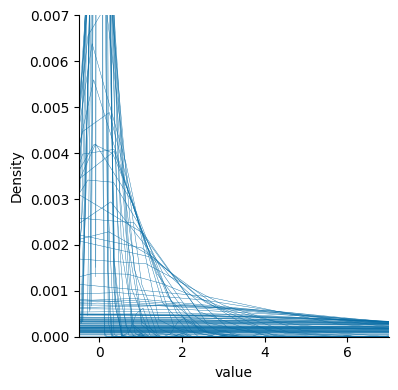

In [62]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_10852\3827610673.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


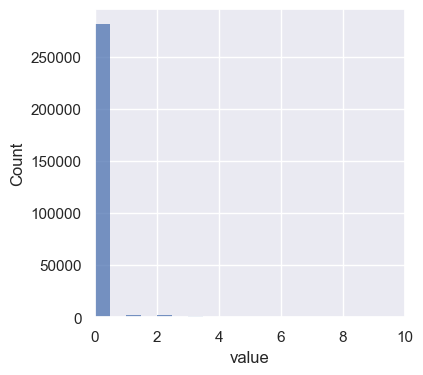

In [63]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
plt.show()

<Axes: ylabel='Count'>

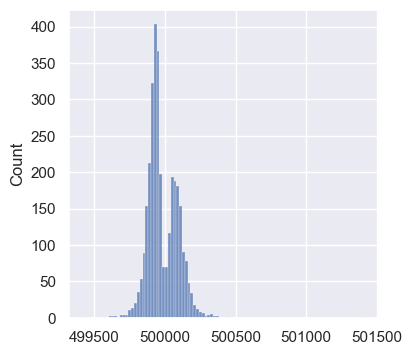

In [64]:
sns.histplot(ad.X.sum(1), bins=100, kde=False)

In [65]:
exp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,5542.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,367.0,0.0,0.0,0.0,...,0.0,4524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2898.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6373.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note: Data is normalized by definition (see file name)

Corresponds to https://betsholtzlab.org/VascularSingleCells/database.html, except for astrocytes

### Astrocytes

In [66]:
ad_astro = sc.read_text(main_dir+"\\P06_vasc_scRNAseq\Vanlandewijck2018\\GSE99058_Brain_AC_250samples_normalized_counts_matrix.txt.gz").transpose() # astrocytes

In [67]:
ad_astro

AnnData object with n_obs × n_vars = 250 × 24490

In [68]:
# format ad_astro.obs

In [69]:
ad_astro.obs.head()

""
Brain.VSMC2_M16
Brain.VSMC2_G3
Brain.VSMC2_O10
Brain.VSMC2_E16
Brain.VSMC2_C7


This is the format of metadata in the anndata object. Corresponds to meta_merged.Sample_description

In [70]:
ad_astro.shape

(250, 24490)

In [71]:
temp = ad_astro.obs.reset_index(level=0)["index"].str.split(pat=".",expand=True)
temp

,0,1
0,Brain,VSMC2_M16
1,Brain,VSMC2_G3
2,Brain,VSMC2_O10
3,Brain,VSMC2_E16
4,Brain,VSMC2_C7
...,...,...
245,Brain,VSMC2_M23
246,Brain,VSMC3_M6
247,Brain,VSMC2_A3
248,Brain,VSMC3_F15


In [72]:
temp["name"] = temp[0] + "." + temp[1]

In [73]:
temp[0].value_counts()

0
Brain    250
Name: count, dtype: int64

In [74]:
temp["tissue"] = temp[0]
temp["cell_id"] = temp[1]

In [75]:
temp

,0,1,name,tissue,cell_id
0,Brain,VSMC2_M16,Brain.VSMC2_M16,Brain,VSMC2_M16
1,Brain,VSMC2_G3,Brain.VSMC2_G3,Brain,VSMC2_G3
2,Brain,VSMC2_O10,Brain.VSMC2_O10,Brain,VSMC2_O10
3,Brain,VSMC2_E16,Brain.VSMC2_E16,Brain,VSMC2_E16
4,Brain,VSMC2_C7,Brain.VSMC2_C7,Brain,VSMC2_C7
...,...,...,...,...,...
245,Brain,VSMC2_M23,Brain.VSMC2_M23,Brain,VSMC2_M23
246,Brain,VSMC3_M6,Brain.VSMC3_M6,Brain,VSMC3_M6
247,Brain,VSMC2_A3,Brain.VSMC2_A3,Brain,VSMC2_A3
248,Brain,VSMC3_F15,Brain.VSMC3_F15,Brain,VSMC3_F15


In [76]:
temp["cell_type_fine"] = temp.cell_id.str.split(pat="_",expand=True)[0]

In [77]:
temp.cell_type_fine.value_counts()

cell_type_fine
VSMC2    162
VSMC3     88
Name: count, dtype: int64

wrong labels?

In [78]:
#temp[temp["cell_type_fine"] == "EC3"].cell_id.unique()

In [79]:
pd.crosstab(temp["cell_type_fine"], temp["cell_id"])

cell_id,VSMC2_A1,VSMC2_A11,VSMC2_A12,VSMC2_A14,VSMC2_A17,VSMC2_A18,VSMC2_A19,VSMC2_A20,VSMC2_A3,VSMC2_A4,...,VSMC3_N7,VSMC3_O1,VSMC3_O10,VSMC3_O11,VSMC3_O14,VSMC3_O18,VSMC3_O21,VSMC3_P11,VSMC3_P18,VSMC3_P19
cell_type_fine,,,,,,,,,,,,,,,,,,,,,
VSMC2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
VSMC3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [80]:
temp['cell_type_broad'] = temp['cell_type_fine'].str.replace('\d+', '')
temp.cell_type_broad.value_counts()

cell_type_broad
VSMC2    162
VSMC3     88
Name: count, dtype: int64

Note: Broad cell types match between metadata and anndata objects

In [81]:
assert all(ad_astro.obs.reset_index()["index"] == temp.name)
assert len(ad_astro.obs) == len(temp)

In [82]:
ad_astro.obs = temp[["tissue","cell_id","cell_type_fine","cell_type_broad","name"]]

In [83]:
ad_astro.obs["annoated cell types"] = "AC"

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_10852\1151037147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_astro.obs["annoated cell types"] = "AC"


Check if data is normalized:

In [84]:
ad_astro.layers

Layers with keys: 

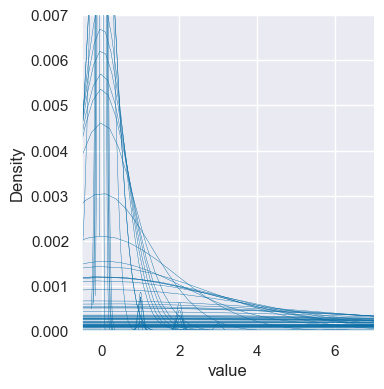

In [85]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad_astro[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_10852\3827610673.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


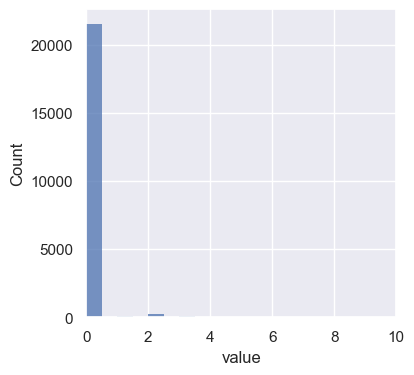

In [86]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
plt.show()

<Axes: ylabel='Count'>

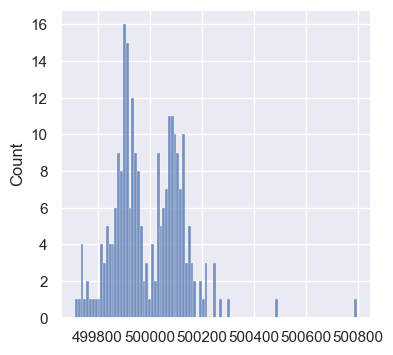

In [87]:
sns.histplot(ad_astro.X.sum(1), bins=100, kde=False)

In [88]:
exp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0
1,0.0,0.0,0.0,0.0,0.0,187.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,0.0,0.0,3.0,0.0,126.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0


Note: Data is normalized by definition (see file name)

### Merge

Merge anndata objects from vasculature and astrocytes

But first, drop 18 ACs from vasculature dataset. In https://betsholtzlab.org/VascularSingleCells/database.html exactly 250 ACs are shown, presumably from the 250 AC dataset.

In [89]:
ad = ad[~ad.obs['annoated cell types'].isin(['AC'])]

In [90]:
ad

View of AnnData object with n_obs × n_vars = 3168 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'GSM ID', 'GSM name', 'organism', 'Mouse ID', 'strain', 'genotype', 'age', 'tissue origin_x', 'annoated cell types', 'BioSample ID', 'SRA ID', 'Sequenced Reads', 'Sample_title', 'Sample_geo_accession', 'tissue origin_y', 'Sample_description'

In [91]:
ad_astro

AnnData object with n_obs × n_vars = 250 × 24490
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types'

In [92]:
ad_merged = anndata.concat([ad, ad_astro], join="inner")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [93]:
ad_merged

AnnData object with n_obs × n_vars = 3418 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types'

In [94]:
ad_merged.obs.head(3)

,tissue,cell_id,cell_type_fine,cell_type_broad,name,annoated cell types
0,Brain,Mural3_A13,Mural3,Mural3,Brain.Mural3_A13,PC
1,Brain,Mural3_A14,Mural3,Mural3,Brain.Mural3_A14,vSMC
2,Brain,Mural3_A6,Mural3,Mural3,Brain.Mural3_A6,PC


In [95]:
ad_merged.obsm['X_umap'] # no umap available as expected

KeyError: 'X_umap'

In [98]:
ad_merged.obs["clusters_fine"] = ad_merged.obs["annoated cell types"]

In [99]:
ad_merged.obs["clusters"] = ad_merged.obs["annoated cell types"]

In [100]:
# merge subclusters
new_names = {
    'ECs': {'EC1','EC2','EC3','aEC','vEC','capilEC'},
    'Pericytes': {'PC'},
    'SMCs': {'aSMC','aaSMC','vSMC'},
    'Oligos': {'OL'},
    'Fibroblasts': {'FB1', 'FB2'},
    'Microglia': {'MG'},
    'Astrocytes': {'AC'}
}
# re-format
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'AC': 'Astrocytes', 'EC1': 'ECs', 'EC2': 'ECs', 'EC3': 'ECs', 'FB1': 'Fibroblasts', 'FB2': 'Fibroblasts', 'MG': 'Microglia', 'OL': 'Oligos', 'PC': 'Pericytes', 'aEC': 'ECs', 'aSMC': 'SMCs', 'aaSMC': 'SMCs', 'capilEC': 'ECs', 'vEC': 'ECs', 'vSMC': 'SMCs'}


In [101]:
ad_merged.obs['clusters'] = (
    ad_merged.obs['clusters']
    .map(new_cluster_names)
    .astype('category')
)

In [102]:
# alternative: keep AV zonation

In [103]:
# merge subclusters
new_names = {
    'ECs_non_AV': {'EC1','EC2','EC3'},
    'ECs_Arterial': {'aEC'},
    'ECs_Capillary': {'capilEC'},
    'ECs_Venous': {'vEC'},
    'Pericytes': {'PC'},
    'SMCs': {'aSMC','aaSMC','vSMC'},
    'Oligos': {'OL'},
    'Fibroblasts': {'FB1', 'FB2'},
    'Microglia': {'MG'},
    'Astrocytes': {'AC'}
}
# re-format
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'AC': 'Astrocytes', 'EC1': 'ECs_non_AV', 'EC2': 'ECs_non_AV', 'EC3': 'ECs_non_AV', 'FB1': 'Fibroblasts', 'FB2': 'Fibroblasts', 'MG': 'Microglia', 'OL': 'Oligos', 'PC': 'Pericytes', 'aEC': 'ECs_Arterial', 'aSMC': 'SMCs', 'aaSMC': 'SMCs', 'capilEC': 'ECs_Capillary', 'vEC': 'ECs_Venous', 'vSMC': 'SMCs'}


In [104]:
# fine annotation
ad_merged.obs['clusters2'] = (
    ad_merged.obs['clusters_fine']
    .map(new_cluster_names)
    .astype('category')
)

In [105]:
ad_merged.obs.clusters.value_counts()

clusters
ECs            1528
Pericytes      1088
SMCs            297
Astrocytes      250
Oligos          155
Fibroblasts      86
Microglia        14
Name: count, dtype: int64

In [106]:
ad_merged.obs.clusters2.value_counts()

clusters2
Pericytes        1088
ECs_non_AV        428
ECs_Capillary     405
ECs_Arterial      397
ECs_Venous        298
SMCs              297
Astrocytes        250
Oligos            155
Fibroblasts        86
Microglia          14
Name: count, dtype: int64

In [107]:
# exclude clusters with <50 cells
cluster_counts = ad_merged.obs['clusters'].value_counts()
cluster_counts

clusters
ECs            1528
Pericytes      1088
SMCs            297
Astrocytes      250
Oligos          155
Fibroblasts      86
Microglia        14
Name: count, dtype: int64

In [108]:
ad_merged = ad_merged[ad_merged.obs['clusters'].isin(cluster_counts[cluster_counts>49].index)]

Check if data is normalized:

In [109]:
ad_merged.layers

LayersView with keys: 

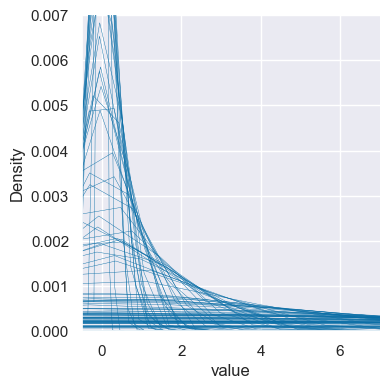

In [110]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad_merged[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_10852\3827610673.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


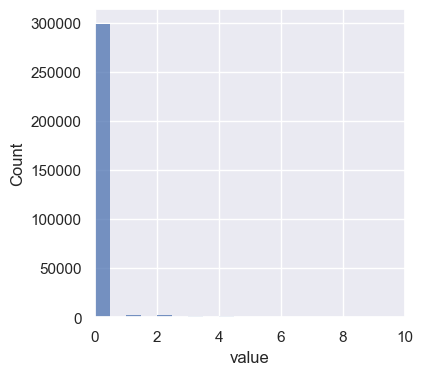

In [111]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
plt.show()

<Axes: ylabel='Count'>

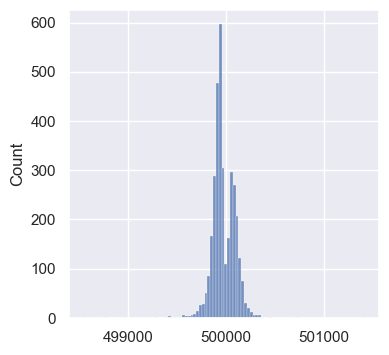

In [112]:
sns.histplot(ad_merged.X.sum(1), bins=100, kde=False)

In [113]:
exp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,505.0,0.0,0.0,...,104.0,0.0,0.0,0.0,0.0,0.0,483.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,39.0,299.0,6.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,145.0,0.0,0.0,0.0,0.0,117.0,60.0,0.0,338.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1849.0,2.0,0.0,0.0


# Log-normalize merged dataest

In [114]:
ad_merged.layers["counts"] = ad_merged.X.copy() # save unnormalized raw RNA counts - retrieve via adata.X = adata.layers["counts"]

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [115]:
sc.pp.normalize_total(ad_merged, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


<Axes: ylabel='Count'>

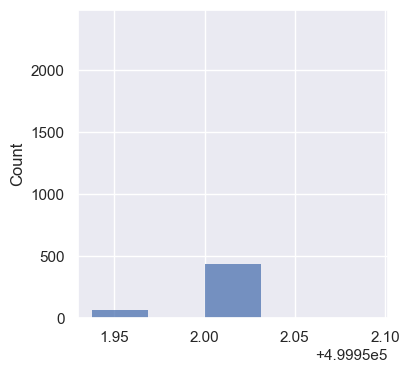

In [116]:
sns.histplot(ad_merged.X.sum(1), kde=False)

In [117]:
sc.pp.log1p(ad_merged) # X = log(X + 1)

<Axes: ylabel='Count'>

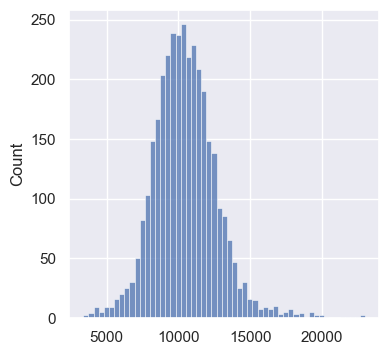

In [118]:
sns.histplot(ad_merged.X.sum(1), kde=False)

In [119]:
ad_merged.layers["normalized"] = ad_merged.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


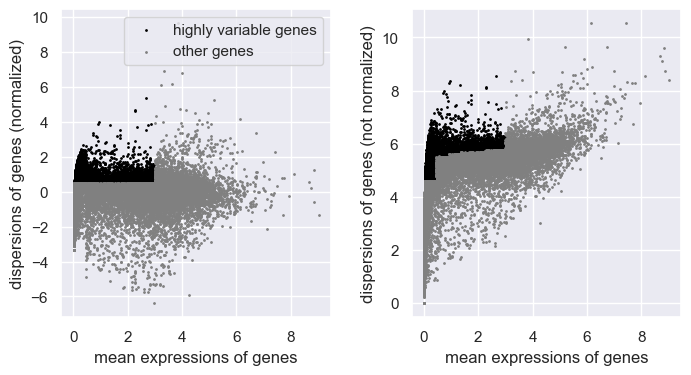

In [120]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(ad_merged)
sc.pl.highly_variable_genes(ad_merged)

In [121]:
ad_merged.layers

Layers with keys: counts, normalized

In [122]:
ad_merged.layers["normalized"]

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        6.8648696],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        7.1315227],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        6.653823 ],
       ...,
       [0.       , 0.       , 0.       , ..., 2.1968691, 0.       ,
        0.       ],
       [3.8313887, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [6.3842916, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

# Focus on: Foxf2

In [130]:
gene="Foxf2"

## Plot

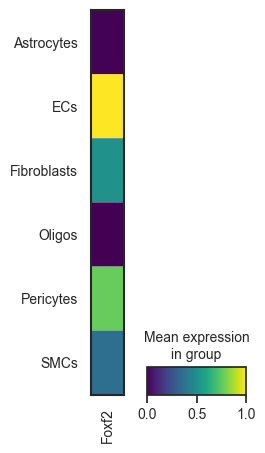

In [157]:
sns.set_theme(style='white')
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

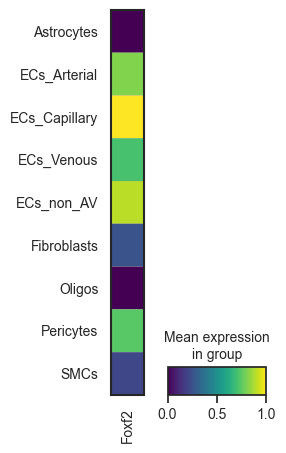

In [150]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


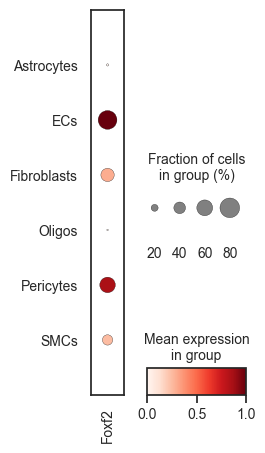

In [151]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


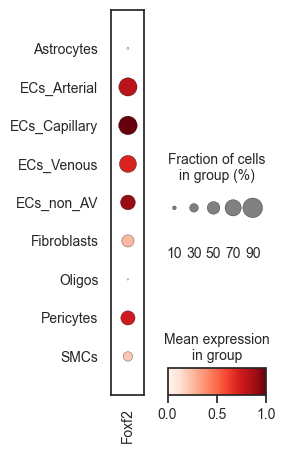

In [152]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

## Excl zonation

In [110]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000066
ECs,1.000000
Fibroblasts,0.293552
Oligos,0.000000
Pericytes,0.853845
SMCs,0.247018


In [111]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.044000
ECs,0.752618
Fibroblasts,0.476744
Oligos,0.025806
Pericytes,0.585478
SMCs,0.340067


In [112]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000066,0.044000,Foxf2,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.752618,Foxf2,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.293552,0.476744,Foxf2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.025806,Foxf2,Vanlandewijck2018,Mouse,155
Pericytes,0.853845,0.585478,Foxf2,Vanlandewijck2018,Mouse,1088
SMCs,0.247018,0.340067,Foxf2,Vanlandewijck2018,Mouse,297


In [113]:
# export
name='Vanlandewijck2018'

In [114]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'.csv',sep=';')

## Incl zonation

In [115]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [116]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [117]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000057,0.044000,Foxf2,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.810197,0.816121,Foxf2,Vanlandewijck2018,Mouse,397
ECs_Capillary,1.000000,0.834568,Foxf2,Vanlandewijck2018,Mouse,405
ECs_Venous,0.707675,0.748322,Foxf2,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.897588,0.619159,Foxf2,Vanlandewijck2018,Mouse,428
Fibroblasts,0.253919,0.476744,Foxf2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.025806,Foxf2,Vanlandewijck2018,Mouse,155
Pericytes,0.738566,0.585478,Foxf2,Vanlandewijck2018,Mouse,1088
SMCs,0.213667,0.340067,Foxf2,Vanlandewijck2018,Mouse,297


In [118]:
# export
name='Vanlandewijck2018'

In [119]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_incl_zonation.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [145]:
gene="Foxo1"

### Plot

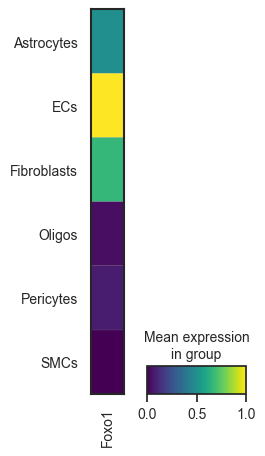

In [146]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

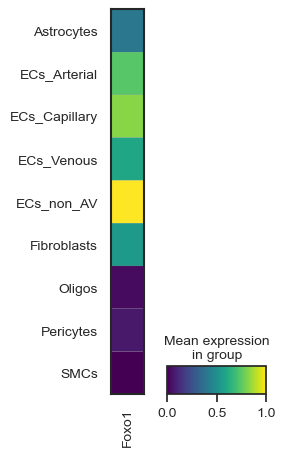

In [122]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

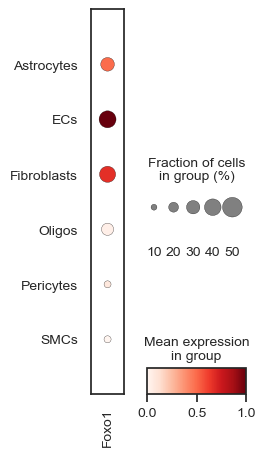

In [123]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

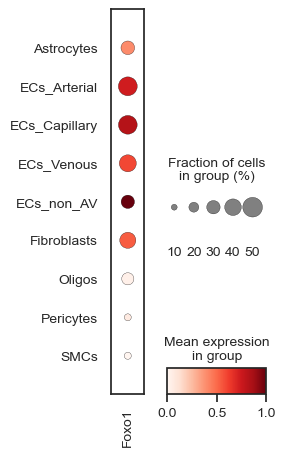

In [124]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [125]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.493353
ECs,1.000000
Fibroblasts,0.667187
Oligos,0.035463
Pericytes,0.079417
SMCs,0.000000


In [126]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.308000
ECs,0.411649
Fibroblasts,0.383721
Oligos,0.264516
Pericytes,0.125919
SMCs,0.127946


In [127]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.493353,0.308000,Foxo1,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.411649,Foxo1,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.667187,0.383721,Foxo1,Vanlandewijck2018,Mouse,86
Oligos,0.035463,0.264516,Foxo1,Vanlandewijck2018,Mouse,155
Pericytes,0.079417,0.125919,Foxo1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.127946,Foxo1,Vanlandewijck2018,Mouse,297


In [128]:
# export
name='Vanlandewijck2018'

In [129]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [130]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [131]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [132]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.397304,0.308000,Foxo1,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.736384,0.473552,Foxo1,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.823155,0.469136,Foxo1,Vanlandewijck2018,Mouse,405
ECs_Venous,0.593278,0.412752,Foxo1,Vanlandewijck2018,Mouse,298
ECs_non_AV,1.000000,0.299065,Foxo1,Vanlandewijck2018,Mouse,428
Fibroblasts,0.537294,0.383721,Foxo1,Vanlandewijck2018,Mouse,86
Oligos,0.028559,0.264516,Foxo1,Vanlandewijck2018,Mouse,155
Pericytes,0.063956,0.125919,Foxo1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.127946,Foxo1,Vanlandewijck2018,Mouse,297


In [133]:
# export
name='Vanlandewijck2018'

In [134]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Tek = Tie2

In [135]:
gene="Tek"

### Plot

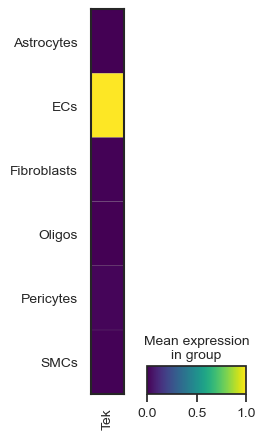

In [136]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

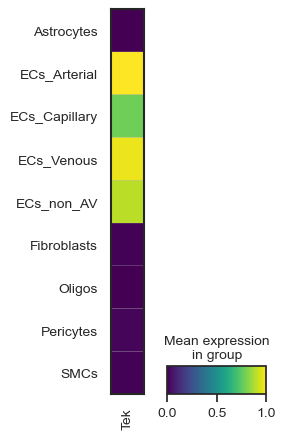

In [137]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

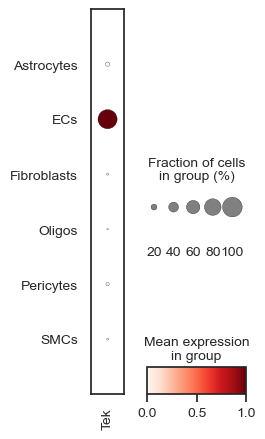

In [138]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

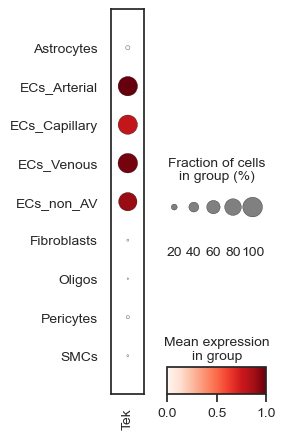

In [139]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [140]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,1.000000
Fibroblasts,0.004707
Oligos,0.000559
Pericytes,0.014129
SMCs,0.004933


In [141]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.132000
ECs,0.965969
Fibroblasts,0.046512
Oligos,0.032258
Pericytes,0.091912
SMCs,0.043771


In [142]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.132000,Tek,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.965969,Tek,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.004707,0.046512,Tek,Vanlandewijck2018,Mouse,86
Oligos,0.000559,0.032258,Tek,Vanlandewijck2018,Mouse,155
Pericytes,0.014129,0.091912,Tek,Vanlandewijck2018,Mouse,1088
SMCs,0.004933,0.043771,Tek,Vanlandewijck2018,Mouse,297


In [143]:
# export
name='Vanlandewijck2018'

In [144]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [145]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [146]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [147]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.132000,Tek,Vanlandewijck2018,Mouse,250
ECs_Arterial,1.000000,0.984887,Tek,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.779048,0.977778,Tek,Vanlandewijck2018,Mouse,405
ECs_Venous,0.970054,0.996644,Tek,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.895323,0.915888,Tek,Vanlandewijck2018,Mouse,428
Fibroblasts,0.004266,0.046512,Tek,Vanlandewijck2018,Mouse,86
Oligos,0.000507,0.032258,Tek,Vanlandewijck2018,Mouse,155
Pericytes,0.012805,0.091912,Tek,Vanlandewijck2018,Mouse,1088
SMCs,0.004471,0.043771,Tek,Vanlandewijck2018,Mouse,297


In [148]:
# export
name='Vanlandewijck2018'

In [149]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Nos3 = eNOS

In [143]:
gene="Nos3"

### Plot

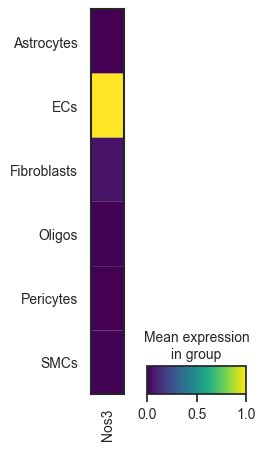

In [144]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

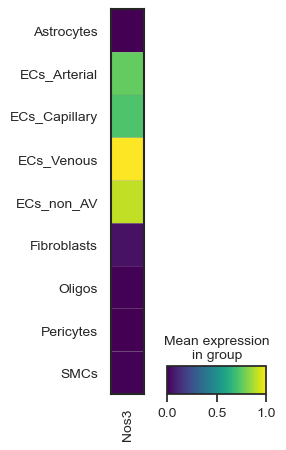

In [152]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

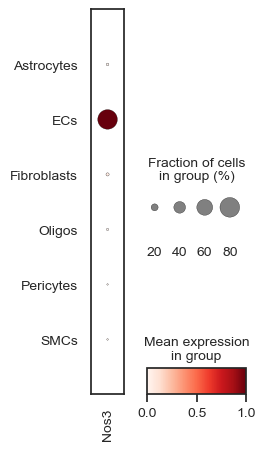

In [153]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

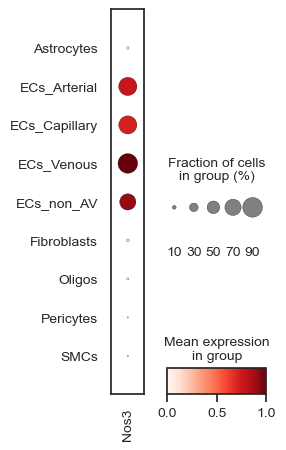

In [154]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [155]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,1.000000
Fibroblasts,0.052781
Oligos,0.005379
Pericytes,0.003093
SMCs,0.005031


In [156]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.056000
ECs,0.797120
Fibroblasts,0.069767
Oligos,0.045161
Pericytes,0.023897
SMCs,0.026936


In [157]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.056000,Nos3,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.797120,Nos3,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.052781,0.069767,Nos3,Vanlandewijck2018,Mouse,86
Oligos,0.005379,0.045161,Nos3,Vanlandewijck2018,Mouse,155
Pericytes,0.003093,0.023897,Nos3,Vanlandewijck2018,Mouse,1088
SMCs,0.005031,0.026936,Nos3,Vanlandewijck2018,Mouse,297


In [158]:
# export
name='Vanlandewijck2018'

In [159]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [160]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [161]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [162]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.056000,Nos3,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.758944,0.816121,Nos3,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.719942,0.807407,Nos3,Vanlandewijck2018,Mouse,405
ECs_Venous,1.000000,0.899329,Nos3,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.903684,0.698598,Nos3,Vanlandewijck2018,Mouse,428
Fibroblasts,0.044134,0.069767,Nos3,Vanlandewijck2018,Mouse,86
Oligos,0.004498,0.045161,Nos3,Vanlandewijck2018,Mouse,155
Pericytes,0.002586,0.023897,Nos3,Vanlandewijck2018,Mouse,1088
SMCs,0.004207,0.026936,Nos3,Vanlandewijck2018,Mouse,297


In [163]:
# export
name='Vanlandewijck2018'

In [164]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Htra1

In [100]:
gene="Htra1"

### Plot

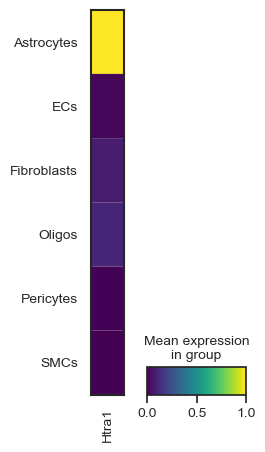

In [101]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

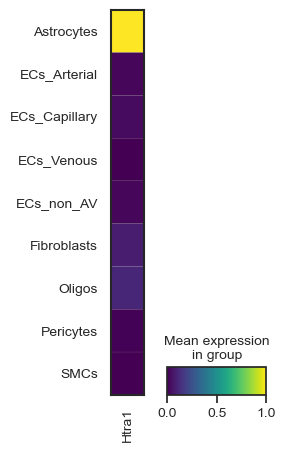

In [102]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

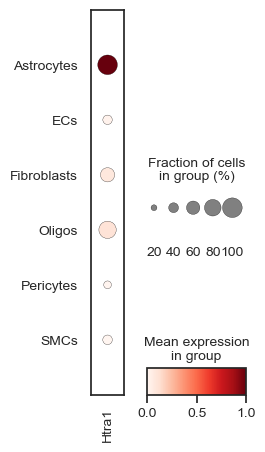

In [103]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

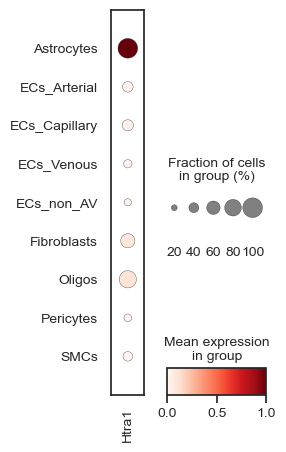

In [104]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [105]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,1.000000
ECs,0.017986
Fibroblasts,0.080460
Oligos,0.107076
Pericytes,0.007577
SMCs,0.000000


In [106]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,1.000000
ECs,0.375000
Fibroblasts,0.651163
Oligos,0.845161
Pericytes,0.288603
SMCs,0.383838


In [107]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,1.000000,1.000000,Htra1,Vanlandewijck2018,Mouse,250
ECs,0.017986,0.375000,Htra1,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.080460,0.651163,Htra1,Vanlandewijck2018,Mouse,86
Oligos,0.107076,0.845161,Htra1,Vanlandewijck2018,Mouse,155
Pericytes,0.007577,0.288603,Htra1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.383838,Htra1,Vanlandewijck2018,Mouse,297


In [108]:
# export
name='Vanlandewijck2018'

In [109]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [110]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [111]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [112]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,1.000000,1.000000,Htra1,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.018875,0.438287,Htra1,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.028745,0.474074,Htra1,Vanlandewijck2018,Mouse,405
ECs_Venous,0.000967,0.318792,Htra1,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.018832,0.261682,Htra1,Vanlandewijck2018,Mouse,428
Fibroblasts,0.080460,0.651163,Htra1,Vanlandewijck2018,Mouse,86
Oligos,0.107076,0.845161,Htra1,Vanlandewijck2018,Mouse,155
Pericytes,0.007577,0.288603,Htra1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.383838,Htra1,Vanlandewijck2018,Mouse,297


In [113]:
# export
name='Vanlandewijck2018'

In [114]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Egfl8

In [116]:
gene="Egfl8"

### Plot

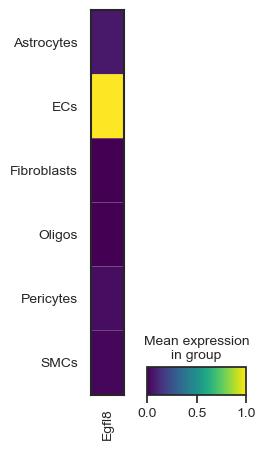

In [117]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

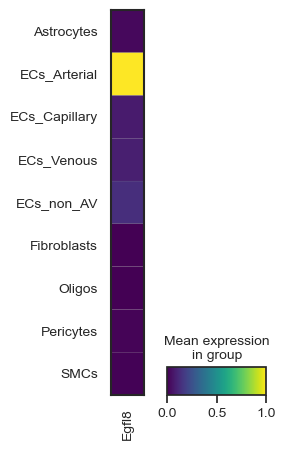

In [118]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

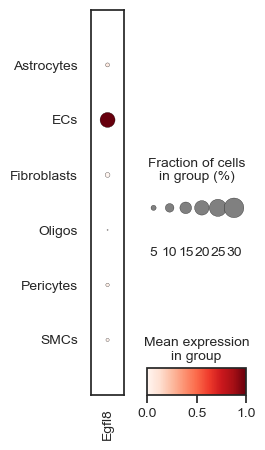

In [119]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

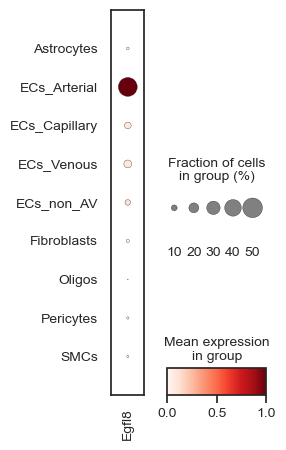

In [120]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [121]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.062616
ECs,1.000000
Fibroblasts,0.001564
Oligos,0.000000
Pericytes,0.033888
SMCs,0.019324


In [122]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.036000
ECs,0.209424
Fibroblasts,0.046512
Oligos,0.006452
Pericytes,0.029412
SMCs,0.026936


In [123]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.062616,0.036000,Egfl8,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.209424,Egfl8,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.001564,0.046512,Egfl8,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Egfl8,Vanlandewijck2018,Mouse,155
Pericytes,0.033888,0.029412,Egfl8,Vanlandewijck2018,Mouse,1088
SMCs,0.019324,0.026936,Egfl8,Vanlandewijck2018,Mouse,297


In [124]:
# export
name='Vanlandewijck2018'

In [125]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [126]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [127]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [128]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.020811,0.036000,Egfl8,Vanlandewijck2018,Mouse,250
ECs_Arterial,1.000000,0.473552,Egfl8,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.072577,0.118519,Egfl8,Vanlandewijck2018,Mouse,405
ECs_Venous,0.084823,0.147651,Egfl8,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.131257,0.093458,Egfl8,Vanlandewijck2018,Mouse,428
Fibroblasts,0.000520,0.046512,Egfl8,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Egfl8,Vanlandewijck2018,Mouse,155
Pericytes,0.011263,0.029412,Egfl8,Vanlandewijck2018,Mouse,1088
SMCs,0.006423,0.026936,Egfl8,Vanlandewijck2018,Mouse,297


In [129]:
# export
name='Vanlandewijck2018'

In [130]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Flt1

In [122]:
gene="Flt1"

### Plot

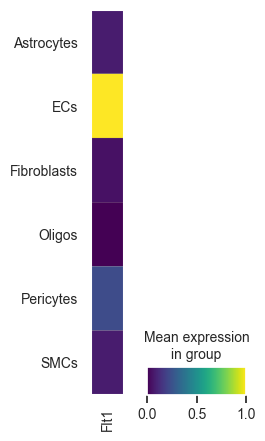

In [123]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

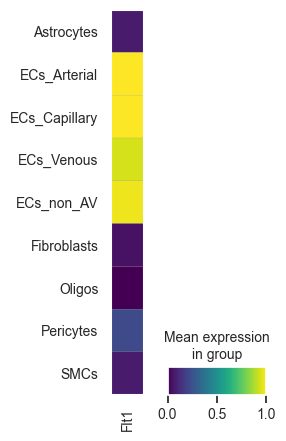

In [124]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


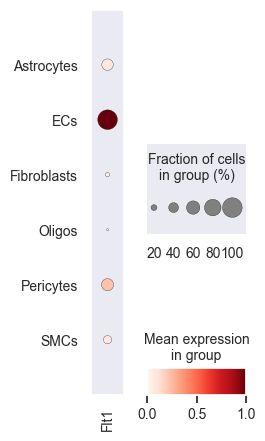

In [125]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


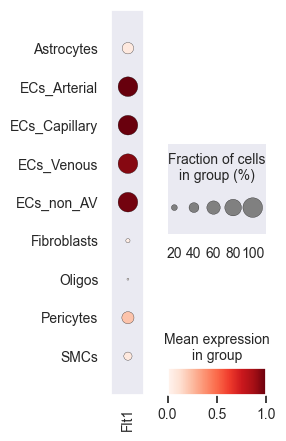

In [126]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [127]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.074942
ECs,1.000000
Fibroblasts,0.044215
Oligos,0.000000
Pericytes,0.229458
SMCs,0.075608


In [128]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.488000
ECs,1.000000
Fibroblasts,0.127907
Oligos,0.045161
Pericytes,0.524816
SMCs,0.313131


In [129]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.074942,0.488000,Flt1,Vanlandewijck2018,Mouse,250
ECs,1.000000,1.000000,Flt1,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.044215,0.127907,Flt1,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.045161,Flt1,Vanlandewijck2018,Mouse,155
Pericytes,0.229458,0.524816,Flt1,Vanlandewijck2018,Mouse,1088
SMCs,0.075608,0.313131,Flt1,Vanlandewijck2018,Mouse,297


In [130]:
# export
name='Vanlandewijck2018'

In [131]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [132]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [133]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [135]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.073311,0.488000,Flt1,Vanlandewijck2018,Mouse,250
ECs_Arterial,1.000000,1.000000,Flt1,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.994071,1.000000,Flt1,Vanlandewijck2018,Mouse,405
ECs_Venous,0.934191,1.000000,Flt1,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.973750,1.000000,Flt1,Vanlandewijck2018,Mouse,428
Fibroblasts,0.043253,0.127907,Flt1,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.045161,Flt1,Vanlandewijck2018,Mouse,155
Pericytes,0.224465,0.524816,Flt1,Vanlandewijck2018,Mouse,1088
SMCs,0.073963,0.313131,Flt1,Vanlandewijck2018,Mouse,297


In [136]:
# export
name='Vanlandewijck2018'

In [137]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Kdr

In [138]:
gene="Kdr"

### Plot

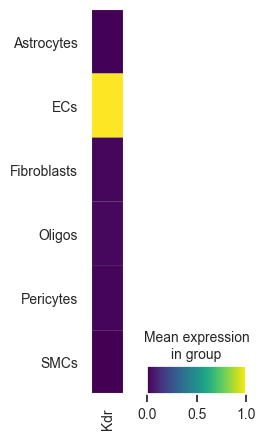

In [139]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

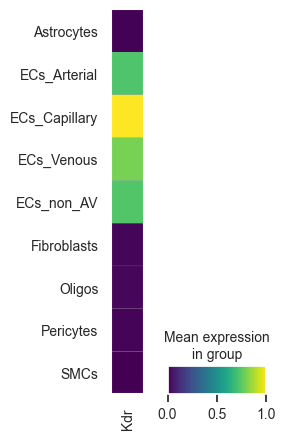

In [140]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


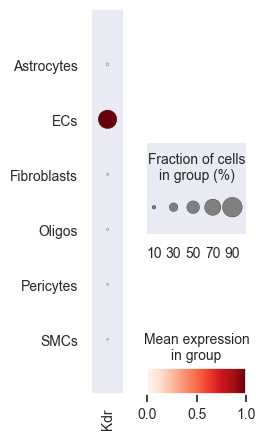

In [141]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


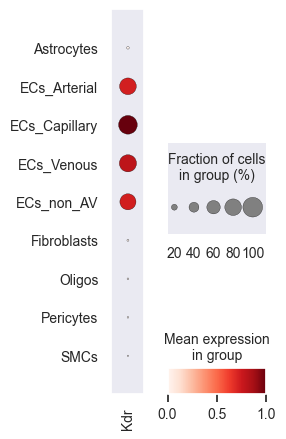

In [144]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [145]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.005954
ECs,1.000000
Fibroblasts,0.019161
Oligos,0.020554
Pericytes,0.012264
SMCs,0.000000


In [146]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.068000
ECs,0.835733
Fibroblasts,0.046512
Oligos,0.038710
Pericytes,0.036765
SMCs,0.030303


In [147]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.005954,0.068000,Kdr,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.835733,Kdr,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.019161,0.046512,Kdr,Vanlandewijck2018,Mouse,86
Oligos,0.020554,0.038710,Kdr,Vanlandewijck2018,Mouse,155
Pericytes,0.012264,0.036765,Kdr,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.030303,Kdr,Vanlandewijck2018,Mouse,297


In [148]:
# export
name='Vanlandewijck2018'

In [149]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [150]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [151]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [152]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.004839,0.068000,Kdr,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.725436,0.808564,Kdr,Vanlandewijck2018,Mouse,397
ECs_Capillary,1.000000,0.935802,Kdr,Vanlandewijck2018,Mouse,405
ECs_Venous,0.794571,0.835570,Kdr,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.729230,0.766355,Kdr,Vanlandewijck2018,Mouse,428
Fibroblasts,0.015573,0.046512,Kdr,Vanlandewijck2018,Mouse,86
Oligos,0.016705,0.038710,Kdr,Vanlandewijck2018,Mouse,155
Pericytes,0.009968,0.036765,Kdr,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.030303,Kdr,Vanlandewijck2018,Mouse,297


In [153]:
# export
name='Vanlandewijck2018'

In [154]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Nrp1

In [155]:
gene="Nrp1"

### Plot

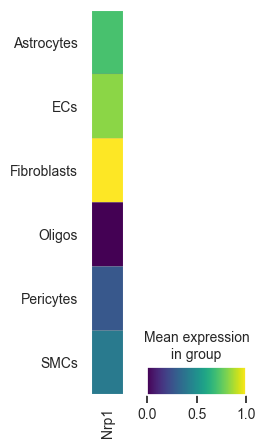

In [156]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

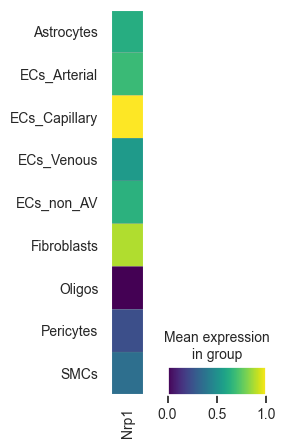

In [157]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


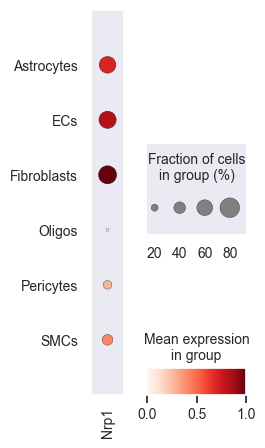

In [158]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


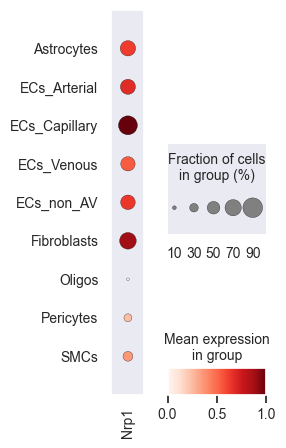

In [159]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [160]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.707654
ECs,0.824337
Fibroblasts,1.000000
Oligos,0.000000
Pericytes,0.272803
SMCs,0.408133


In [161]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.648000
ECs,0.674738
Fibroblasts,0.720930
Oligos,0.064516
Pericytes,0.268382
SMCs,0.356902


In [162]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.707654,0.648000,Nrp1,Vanlandewijck2018,Mouse,250
ECs,0.824337,0.674738,Nrp1,Vanlandewijck2018,Mouse,1528
Fibroblasts,1.000000,0.720930,Nrp1,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.064516,Nrp1,Vanlandewijck2018,Mouse,155
Pericytes,0.272803,0.268382,Nrp1,Vanlandewijck2018,Mouse,1088
SMCs,0.408133,0.356902,Nrp1,Vanlandewijck2018,Mouse,297


In [163]:
# export
name='Vanlandewijck2018'

In [164]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [165]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [166]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [167]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.623166,0.648000,Nrp1,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.676377,0.629723,Nrp1,Vanlandewijck2018,Mouse,397
ECs_Capillary,1.000000,0.854321,Nrp1,Vanlandewijck2018,Mouse,405
ECs_Venous,0.542619,0.590604,Nrp1,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.640145,0.605140,Nrp1,Vanlandewijck2018,Mouse,428
Fibroblasts,0.880609,0.720930,Nrp1,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.064516,Nrp1,Vanlandewijck2018,Mouse,155
Pericytes,0.240233,0.268382,Nrp1,Vanlandewijck2018,Mouse,1088
SMCs,0.359405,0.356902,Nrp1,Vanlandewijck2018,Mouse,297


In [168]:
# export
name='Vanlandewijck2018'

In [169]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Nrp2

In [170]:
gene="Nrp2"

### Plot

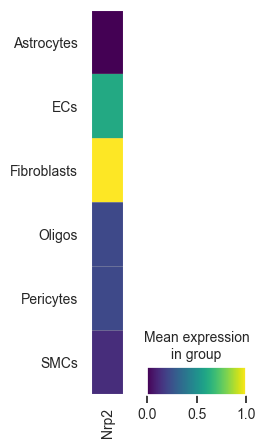

In [171]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

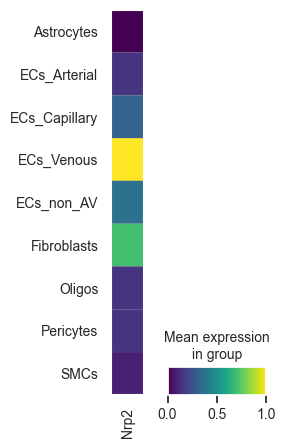

In [172]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


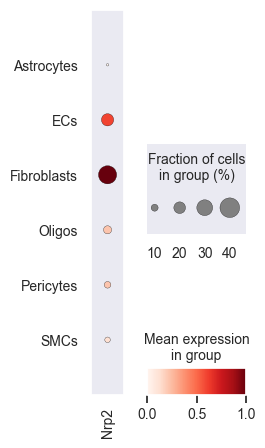

In [173]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


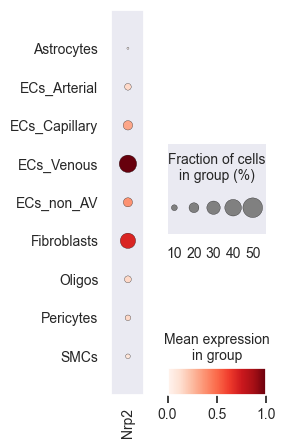

In [174]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [175]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,0.601950
Fibroblasts,1.000000
Oligos,0.220895
Pericytes,0.221769
SMCs,0.128567


In [176]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.024000
ECs,0.214005
Fibroblasts,0.360465
Oligos,0.122581
Pericytes,0.093750
SMCs,0.074074


In [177]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.024000,Nrp2,Vanlandewijck2018,Mouse,250
ECs,0.601950,0.214005,Nrp2,Vanlandewijck2018,Mouse,1528
Fibroblasts,1.000000,0.360465,Nrp2,Vanlandewijck2018,Mouse,86
Oligos,0.220895,0.122581,Nrp2,Vanlandewijck2018,Mouse,155
Pericytes,0.221769,0.093750,Nrp2,Vanlandewijck2018,Mouse,1088
SMCs,0.128567,0.074074,Nrp2,Vanlandewijck2018,Mouse,297


In [178]:
# export
name='Vanlandewijck2018'

In [179]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [180]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [181]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [182]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.024000,Nrp2,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.150609,0.118388,Nrp2,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.315213,0.187654,Nrp2,Vanlandewijck2018,Mouse,405
ECs_Venous,1.000000,0.426174,Nrp2,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.375903,0.179907,Nrp2,Vanlandewijck2018,Mouse,428
Fibroblasts,0.702711,0.360465,Nrp2,Vanlandewijck2018,Mouse,86
Oligos,0.155225,0.122581,Nrp2,Vanlandewijck2018,Mouse,155
Pericytes,0.155840,0.093750,Nrp2,Vanlandewijck2018,Mouse,1088
SMCs,0.090346,0.074074,Nrp2,Vanlandewijck2018,Mouse,297


In [183]:
# export
name='Vanlandewijck2018'

In [184]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Efnb2

In [185]:
gene="Efnb2"

### Plot

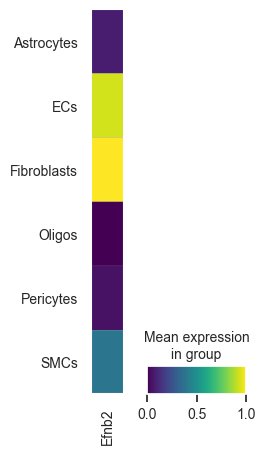

In [186]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

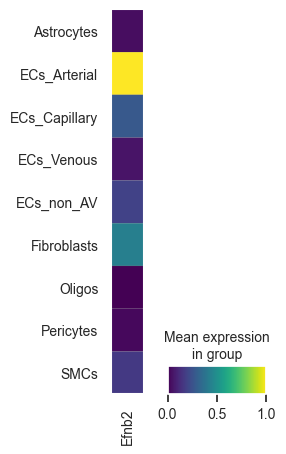

In [187]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


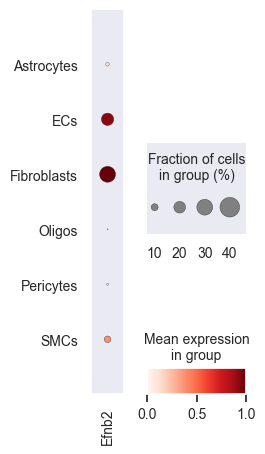

In [188]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


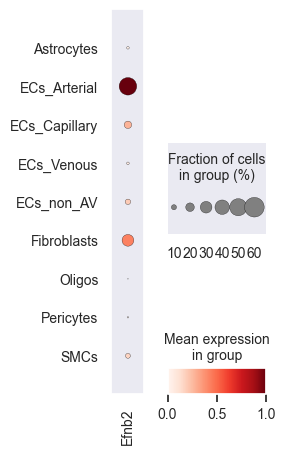

In [189]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [190]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.079611
ECs,0.932166
Fibroblasts,1.000000
Oligos,0.000000
Pericytes,0.046707
SMCs,0.388910


In [191]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.040000
ECs,0.215314
Fibroblasts,0.302326
Oligos,0.006452
Pericytes,0.017463
SMCs,0.094276


In [192]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.079611,0.040000,Efnb2,Vanlandewijck2018,Mouse,250
ECs,0.932166,0.215314,Efnb2,Vanlandewijck2018,Mouse,1528
Fibroblasts,1.000000,0.302326,Efnb2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Efnb2,Vanlandewijck2018,Mouse,155
Pericytes,0.046707,0.017463,Efnb2,Vanlandewijck2018,Mouse,1088
SMCs,0.388910,0.094276,Efnb2,Vanlandewijck2018,Mouse,297


In [193]:
# export
name='Vanlandewijck2018'

In [194]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [195]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [196]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [197]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.034032,0.040000,Efnb2,Vanlandewijck2018,Mouse,250
ECs_Arterial,1.000000,0.516373,Efnb2,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.274011,0.162963,Efnb2,Vanlandewijck2018,Mouse,405
ECs_Venous,0.053475,0.040268,Efnb2,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.198532,0.107477,Efnb2,Vanlandewijck2018,Mouse,428
Fibroblasts,0.427480,0.302326,Efnb2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Efnb2,Vanlandewijck2018,Mouse,155
Pericytes,0.019966,0.017463,Efnb2,Vanlandewijck2018,Mouse,1088
SMCs,0.166251,0.094276,Efnb2,Vanlandewijck2018,Mouse,297


In [198]:
# export
name='Vanlandewijck2018'

In [199]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Itgb1

In [200]:
gene="Itgb1"

### Plot

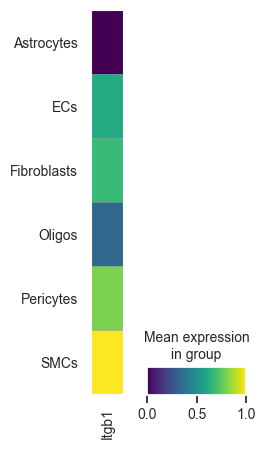

In [201]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

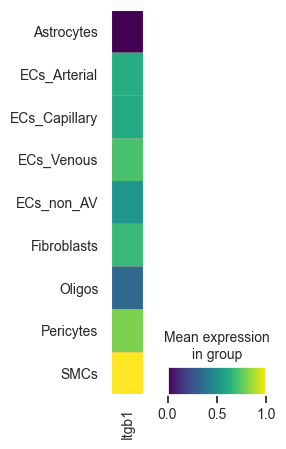

In [202]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


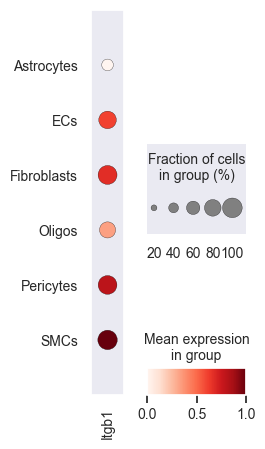

In [203]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


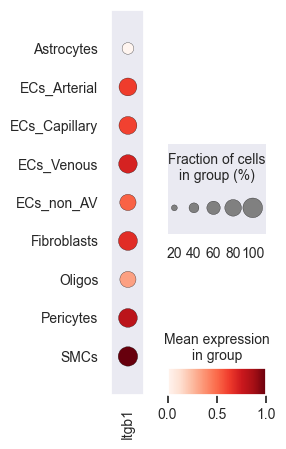

In [204]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [205]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,0.608118
Fibroblasts,0.673623
Oligos,0.334970
Pericytes,0.800994
SMCs,1.000000


In [206]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.500000
ECs,0.861911
Fibroblasts,0.953488
Oligos,0.767742
Pericytes,0.941176
SMCs,0.986532


In [207]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.500000,Itgb1,Vanlandewijck2018,Mouse,250
ECs,0.608118,0.861911,Itgb1,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.673623,0.953488,Itgb1,Vanlandewijck2018,Mouse,86
Oligos,0.334970,0.767742,Itgb1,Vanlandewijck2018,Mouse,155
Pericytes,0.800994,0.941176,Itgb1,Vanlandewijck2018,Mouse,1088
SMCs,1.000000,0.986532,Itgb1,Vanlandewijck2018,Mouse,297


In [208]:
# export
name='Vanlandewijck2018'

In [209]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [210]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [211]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [212]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.500000,Itgb1,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.621715,0.881612,Itgb1,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.609016,0.886420,Itgb1,Vanlandewijck2018,Mouse,405
ECs_Venous,0.711003,0.922819,Itgb1,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.523023,0.778037,Itgb1,Vanlandewijck2018,Mouse,428
Fibroblasts,0.673623,0.953488,Itgb1,Vanlandewijck2018,Mouse,86
Oligos,0.334970,0.767742,Itgb1,Vanlandewijck2018,Mouse,155
Pericytes,0.800994,0.941176,Itgb1,Vanlandewijck2018,Mouse,1088
SMCs,1.000000,0.986532,Itgb1,Vanlandewijck2018,Mouse,297


In [213]:
# export
name='Vanlandewijck2018'

In [214]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Angpt2

In [215]:
gene="Angpt2"

### Plot

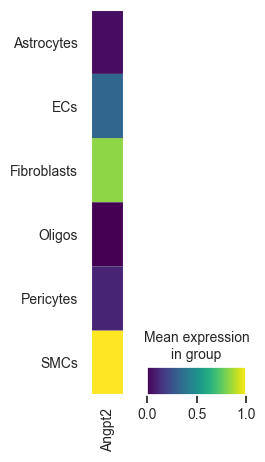

In [216]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

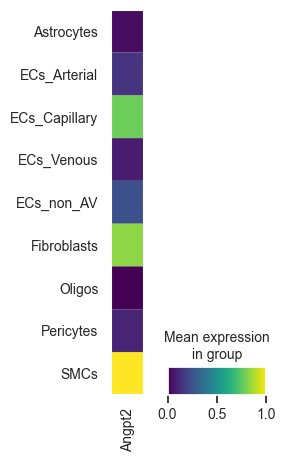

In [217]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


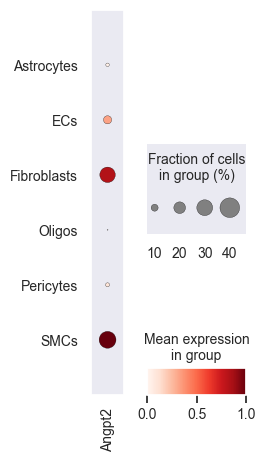

In [218]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


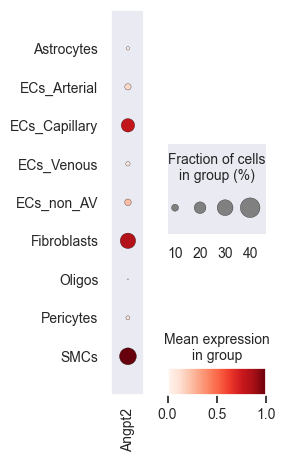

In [219]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [220]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.032772
ECs,0.327012
Fibroblasts,0.831617
Oligos,0.000000
Pericytes,0.099841
SMCs,1.000000


In [221]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.040000
ECs,0.123691
Fibroblasts,0.290698
Oligos,0.006452
Pericytes,0.047794
SMCs,0.326599


In [222]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.032772,0.040000,Angpt2,Vanlandewijck2018,Mouse,250
ECs,0.327012,0.123691,Angpt2,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.831617,0.290698,Angpt2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Angpt2,Vanlandewijck2018,Mouse,155
Pericytes,0.099841,0.047794,Angpt2,Vanlandewijck2018,Mouse,1088
SMCs,1.000000,0.326599,Angpt2,Vanlandewijck2018,Mouse,297


In [223]:
# export
name='Vanlandewijck2018'

In [224]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [225]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [226]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [227]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.032772,0.040000,Angpt2,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.148448,0.088161,Angpt2,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.776689,0.241975,Angpt2,Vanlandewijck2018,Mouse,405
ECs_Venous,0.075143,0.053691,Angpt2,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.242498,0.093458,Angpt2,Vanlandewijck2018,Mouse,428
Fibroblasts,0.831617,0.290698,Angpt2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Angpt2,Vanlandewijck2018,Mouse,155
Pericytes,0.099841,0.047794,Angpt2,Vanlandewijck2018,Mouse,1088
SMCs,1.000000,0.326599,Angpt2,Vanlandewijck2018,Mouse,297


In [228]:
# export
name='Vanlandewijck2018'

In [229]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Cdh5

In [123]:
gene="Cdh5"

### Plot

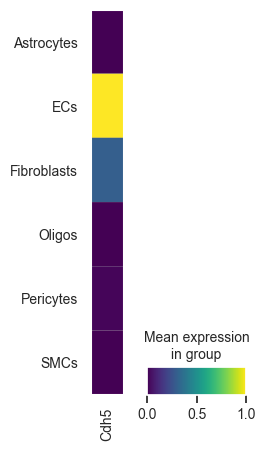

In [124]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

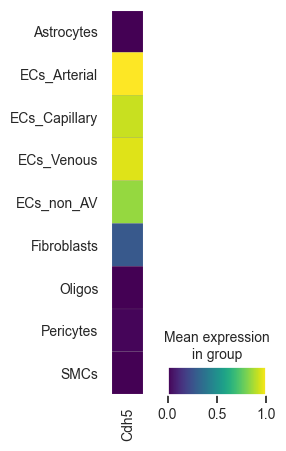

In [125]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


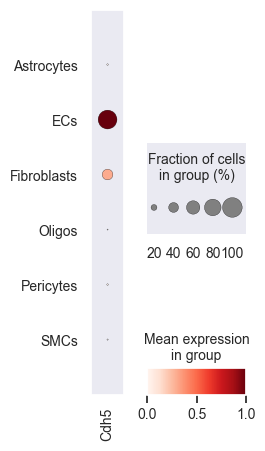

In [126]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


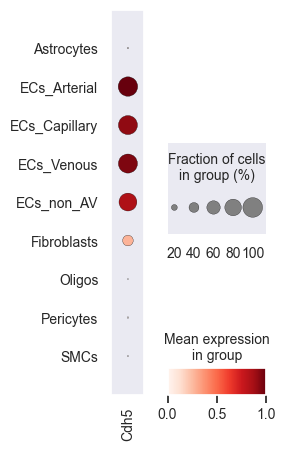

In [127]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [128]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,1.000000
Fibroblasts,0.298633
Oligos,0.000775
Pericytes,0.014279
SMCs,0.000951


In [129]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.032000
ECs,0.946335
Fibroblasts,0.441860
Oligos,0.019355
Pericytes,0.032169
SMCs,0.023569


In [130]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.032000,Cdh5,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.946335,Cdh5,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.298633,0.441860,Cdh5,Vanlandewijck2018,Mouse,86
Oligos,0.000775,0.019355,Cdh5,Vanlandewijck2018,Mouse,155
Pericytes,0.014279,0.032169,Cdh5,Vanlandewijck2018,Mouse,1088
SMCs,0.000951,0.023569,Cdh5,Vanlandewijck2018,Mouse,297


In [131]:
# export
name='Vanlandewijck2018'

In [132]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [133]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [134]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [135]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Vanlandewijck2018"
othergene['organism'] = "Mouse"
othergene['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.032000,Cdh5,Vanlandewijck2018,Mouse,250
ECs_Arterial,1.000000,0.987406,Cdh5,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.915710,0.960494,Cdh5,Vanlandewijck2018,Mouse,405
ECs_Venous,0.951104,0.963087,Cdh5,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.841679,0.883178,Cdh5,Vanlandewijck2018,Mouse,428
Fibroblasts,0.275870,0.441860,Cdh5,Vanlandewijck2018,Mouse,86
Oligos,0.000716,0.019355,Cdh5,Vanlandewijck2018,Mouse,155
Pericytes,0.013191,0.032169,Cdh5,Vanlandewijck2018,Mouse,1088
SMCs,0.000879,0.023569,Cdh5,Vanlandewijck2018,Mouse,297


In [136]:
# export
name='Vanlandewijck2018'

In [137]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

# Correlate gene expression (Foxf2 and Foxo1)

Using MAGIC denoising

In [121]:
import magic
import scprep

In [122]:
#sc.pp.scale(ad_merged)

In [136]:
sns.set_theme(style='white')

## ECs

In [123]:
gg = ["Foxf2","Foxo1","Nos3"]

In [124]:
adata_EC = ad_merged[ad_merged.obs.clusters == "ECs"]

In [125]:
adata_EC

View of AnnData object with n_obs × n_vars = 1528 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types', 'clusters_fine', 'clusters', 'clusters2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [126]:
adata_EC.layers

LayersView with keys: counts, normalized

In [127]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [128]:
cutoff_var = None

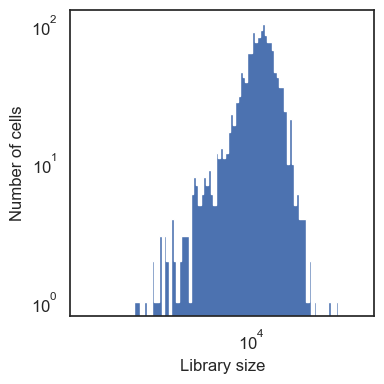

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [137]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [130]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [131]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [132]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [133]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 1528 cells and 19937 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.26 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.27 seconds.
    Calculating affinities...
    Calculated affinities in 0.25 seconds.
  Calculated graph and diffusion operator in 1.85 seconds.
  Calculating imputation...
Calculated MAGIC in 1.97 seconds.
CPU times: total: 4.78 s
Wall time: 1.98 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [134]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.865198495073009

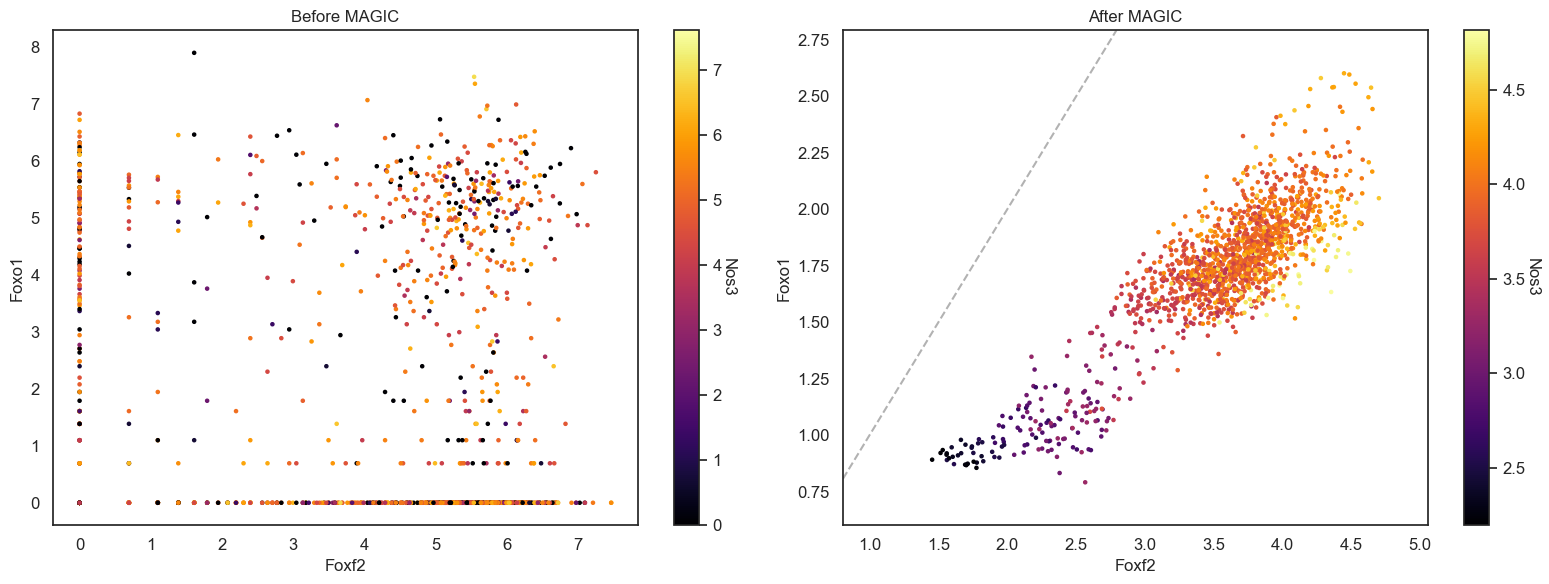

In [139]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X, y=adata_EC[:,'Foxo1'].X, c=adata_EC[:,'Nos3'].X, ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## PCs

In [140]:
gg = ["Foxf2","Foxo1","Nos3"]

In [141]:
adata_EC = ad_merged[ad_merged.obs.clusters == "Pericytes"]

In [142]:
adata_EC

View of AnnData object with n_obs × n_vars = 1088 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types', 'clusters_fine', 'clusters', 'clusters2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [143]:
adata_EC.layers

LayersView with keys: counts, normalized

In [144]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [145]:
cutoff_var = None

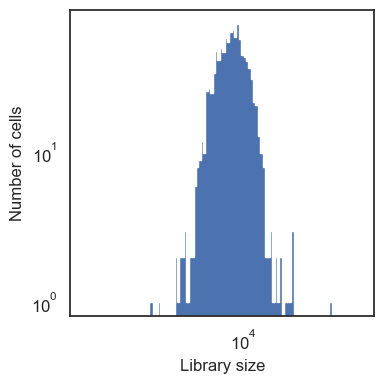

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [146]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [147]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [148]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [149]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [150]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 1088 cells and 19937 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.14 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 1.34 seconds.
  Calculating imputation...
Calculated MAGIC in 1.45 seconds.
CPU times: total: 3.95 s
Wall time: 1.46 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [151]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.2237361855165196

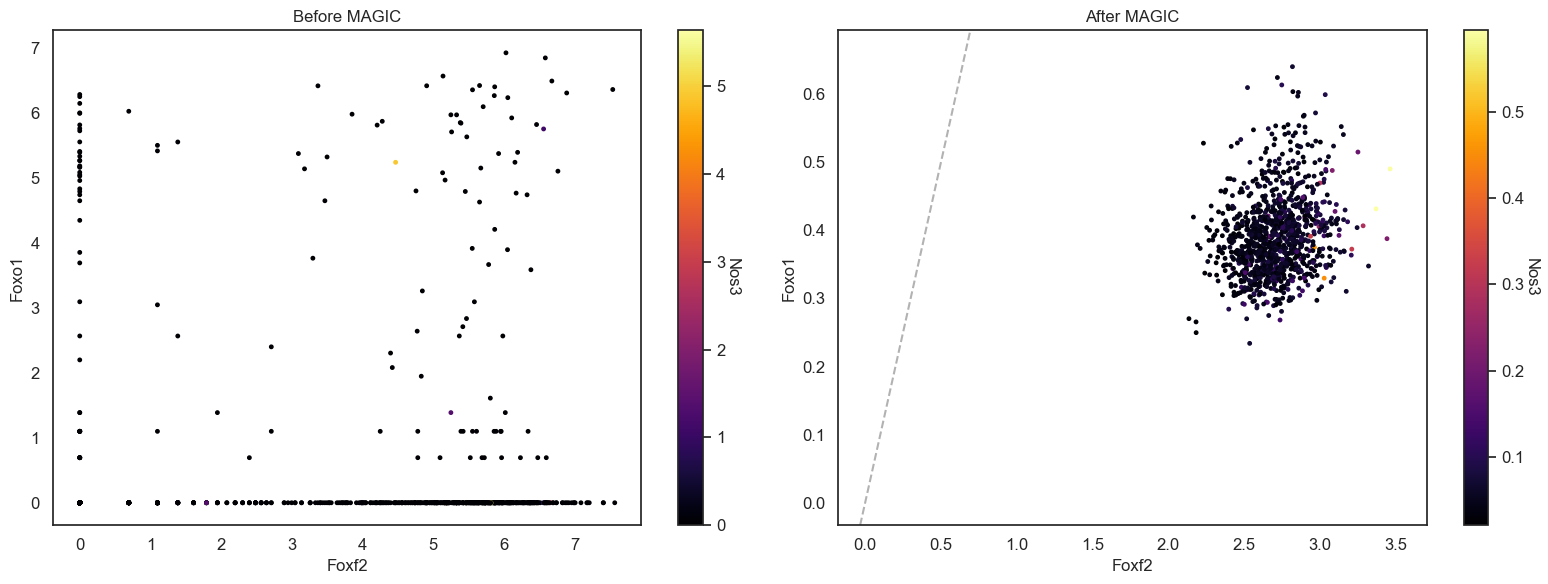

In [152]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X, y=adata_EC[:,'Foxo1'].X, c=adata_EC[:,'Nos3'].X, ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## All cell types

In [153]:
gg = ["Foxf2","Foxo1"]

In [154]:
ad_merged

AnnData object with n_obs × n_vars = 3404 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types', 'clusters_fine', 'clusters', 'clusters2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [155]:
#matrix = pd.DataFrame(adata.X) # not compatible with sparse 
matrix = ad_merged.X
#matrix.columns = ad_merged.var.index.tolist()

In [156]:
cutoff_var = 700

C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\scprep\plot\histogram.py:180: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axvline(cutoff, color="red")


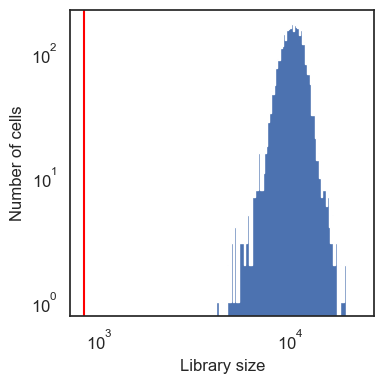

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [157]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [158]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [159]:
ad_merged.layers

Layers with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [160]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [161]:
%%time
emt_magic = magic_op.fit_transform(ad_merged, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 3404 cells and 19937 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.26 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.01 seconds.
    Calculating affinities...
    Calculated affinities in 1.00 seconds.
  Calculated graph and diffusion operator in 4.28 seconds.
  Calculating imputation...
Calculated MAGIC in 4.35 seconds.
CPU times: total: 11.1 s
Wall time: 4.35 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [162]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.4930150861132215

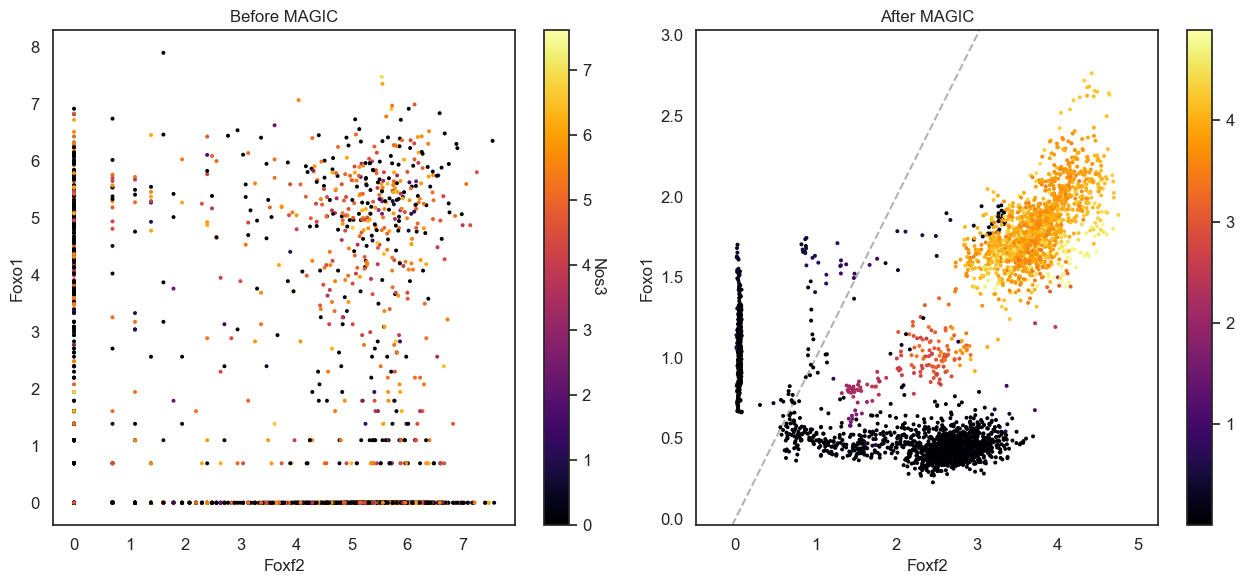

In [164]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13, 6))

scprep.plot.scatter(x=ad_merged[:,'Foxf2'].X, y=ad_merged[:,'Foxo1'].X, c=ad_merged[:,'Nos3'].X, ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')

scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## capECs

In [165]:
gg = ["Foxf2","Foxo1","Nos3"]

In [166]:
adata_EC = ad_merged[ad_merged.obs.clusters2 == "ECs_Capillary"]

In [167]:
adata_EC

View of AnnData object with n_obs × n_vars = 405 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types', 'clusters_fine', 'clusters', 'clusters2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [168]:
adata_EC.layers

LayersView with keys: counts, normalized

In [169]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [170]:
cutoff_var = None

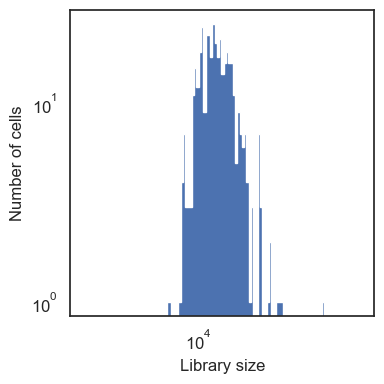

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [171]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [172]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [173]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [174]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [175]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 405 cells and 19937 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.39 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.46 seconds.
  Calculating imputation...
Calculated MAGIC in 0.53 seconds.
CPU times: total: 1.17 s
Wall time: 536 ms


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [176]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.5780882347168946

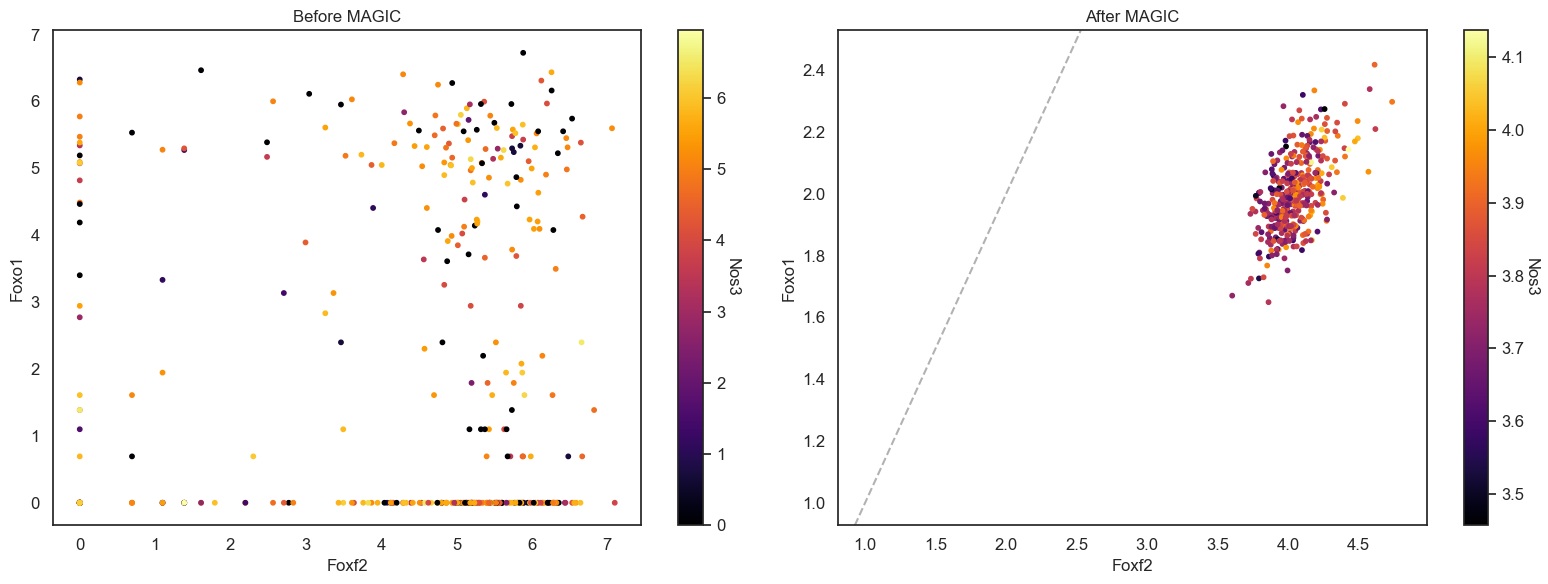

In [179]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X, y=adata_EC[:,'Foxo1'].X, c=adata_EC[:,'Nos3'].X, ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## aECs

In [180]:
gg = ["Foxf2","Foxo1","Nos3"]

In [181]:
adata_EC = ad_merged[ad_merged.obs.clusters2 == "ECs_Arterial"]

In [182]:
adata_EC

View of AnnData object with n_obs × n_vars = 397 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types', 'clusters_fine', 'clusters', 'clusters2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [183]:
adata_EC.layers

LayersView with keys: counts, normalized

In [184]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [185]:
cutoff_var = None

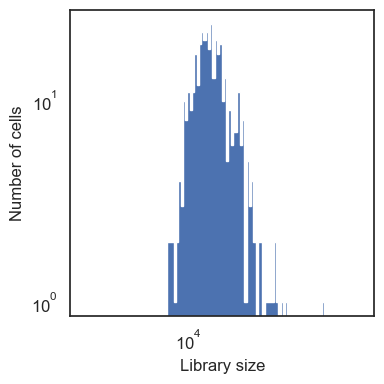

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [186]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [187]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [188]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [189]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [190]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 397 cells and 19937 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.38 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.44 seconds.
  Calculating imputation...
Calculated MAGIC in 0.51 seconds.
CPU times: total: 1.19 s
Wall time: 512 ms


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [191]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.610599265756814

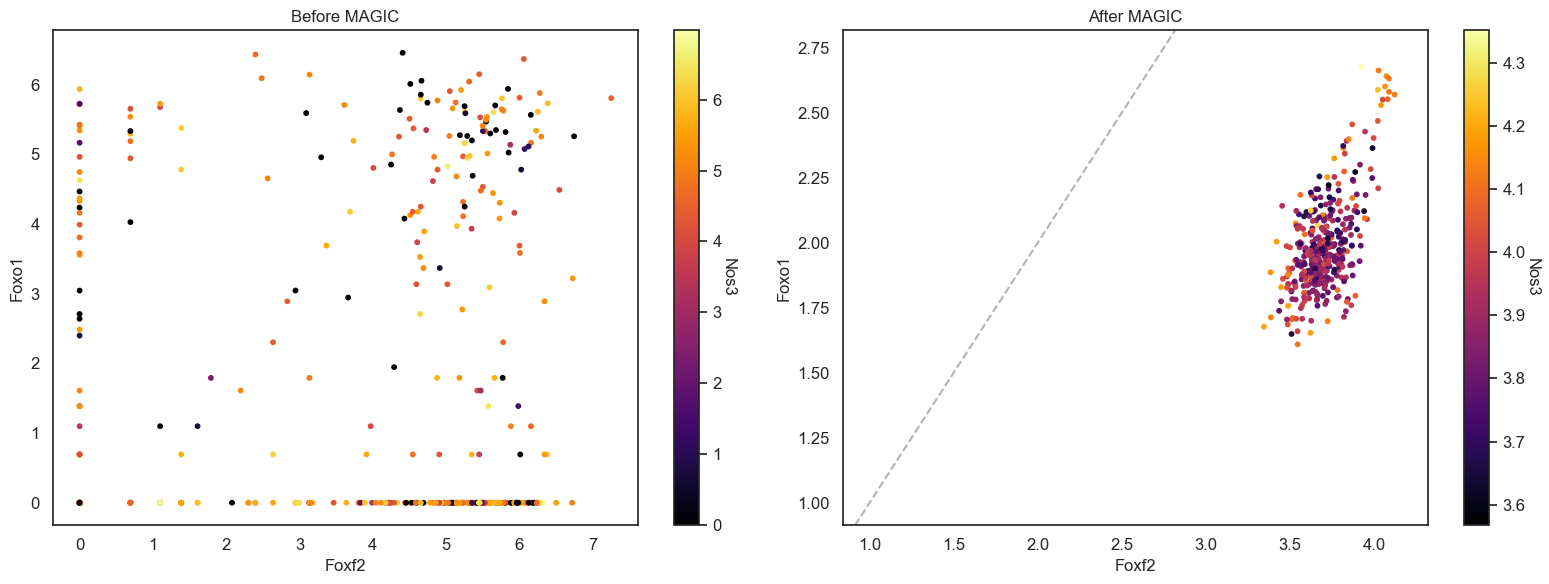

In [193]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X, y=adata_EC[:,'Foxo1'].X, c=adata_EC[:,'Nos3'].X, ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## vECs

In [194]:
gg = ["Foxf2","Foxo1","Nos3"]

In [195]:
adata_EC = ad_merged[ad_merged.obs.clusters2 == "ECs_Venous"]

In [196]:
adata_EC

View of AnnData object with n_obs × n_vars = 298 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types', 'clusters_fine', 'clusters', 'clusters2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [197]:
adata_EC.layers

LayersView with keys: counts, normalized

In [198]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [199]:
cutoff_var = None

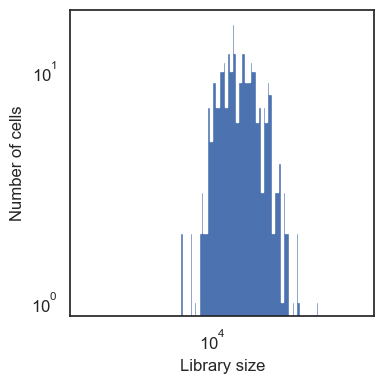

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [200]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [201]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [202]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [203]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [204]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 298 cells and 19937 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.38 seconds.
  Calculating imputation...
Calculated MAGIC in 0.45 seconds.
CPU times: total: 1.22 s
Wall time: 447 ms


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [205]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.06861148995440927

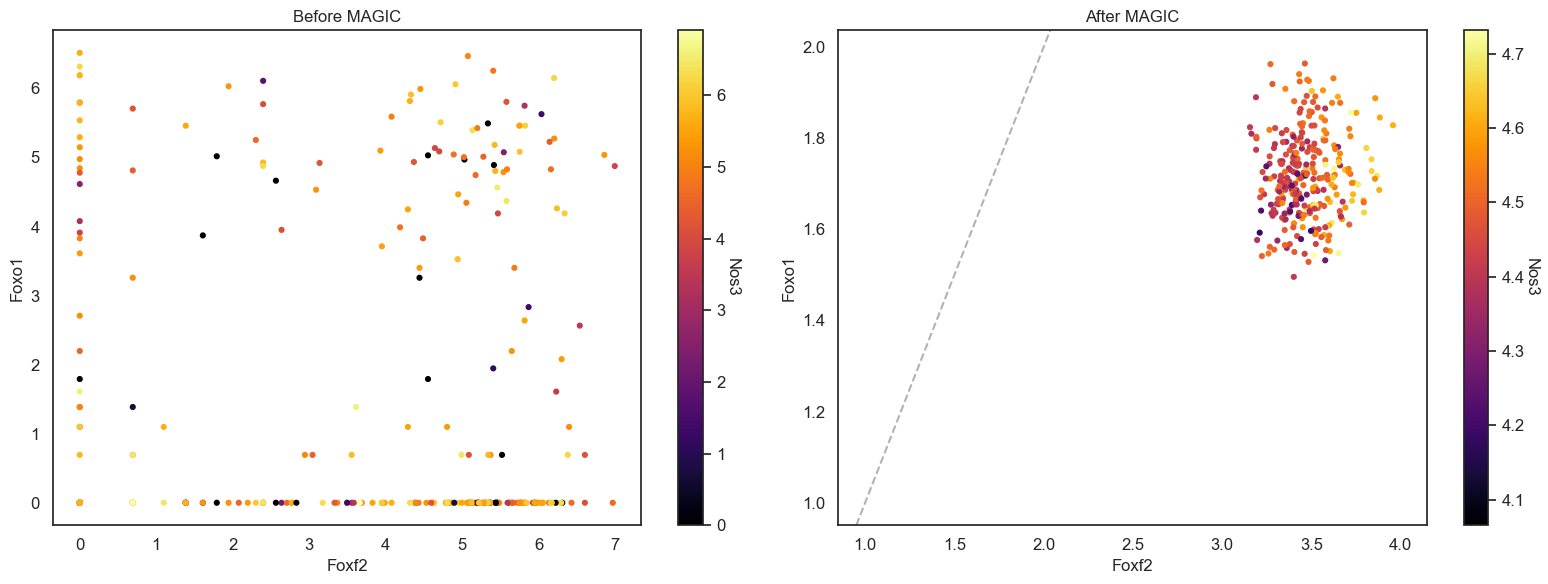

In [208]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X, y=adata_EC[:,'Foxo1'].X, c=adata_EC[:,'Nos3'].X, ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Session Info

In [381]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
anyio               NA
asttokens           NA
attr                22.1.0
babel               2.11.0
backcall            0.2.0
brotli              NA
certifi             2023.07.22
cffi                1.15.1
charset_normalizer  2.0.4
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
deprecated          1.2.14
entrypoints         0.4
executing           0.8.3
fastjsonschema      NA
future              0.18.3
graphtools          1.5.3
h5py                3.9.0
idna                3.4
igraph              0.10.4
ipykernel           6.25.0
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.1
jinja2              3.0.3
joblib              1.3.2
json5               NA
jsonschema          4.17.3
jupyter_server      1.23.4
jupyterlab_server   2